# Obtenção de rating do contribuinte

Com o objetivo de direcionar o modelo que ditá quais dívidas são melhores de recuperar, será realizado um rating que envolva apenas as variáveis do contribuinte.

In [1]:
import os
import dotenv
import zipfile
import pandas as pd
import numpy as np
from datetime import date

import boto3
from io import BytesIO
import pickle

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

import pickle
import shutil

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

import warnings
warnings.filterwarnings("ignore")

rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

True

In [2]:
def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

def up_s3_files(dataframe, bucket_name, folder_name, file_name):
    csv_buffer = BytesIO()
    dataframe.to_csv(csv_buffer, sep=';', index=False)
    file_key_aws = folder_name + file_name
    s3_resource.Object(bucket_name, file_key_aws).put(Body=csv_buffer.getvalue())

In [3]:
dataPath

'c:\\Users\\BHN\\datascience\\divida_ativa\\data'

# 01) Importando dados

In [3]:
zip_file = os.path.join(dataPath, 'rating_igr_25_10.zip')
z = zipfile.ZipFile(zip_file)

In [4]:
def ler_bases_exportadas(nome_arquivo):
    z.extract(nome_arquivo)
    df = pd.read_csv(nome_arquivo, sep=',')
    os.remove(nome_arquivo)
    return df

In [5]:
base_notas_fiscais = ler_bases_exportadas('emissao_notas2.csv')
base_conjunta = ler_bases_exportadas('emissao_notas.csv')

In [6]:
base_conjunta[['id_pessoa', 'tipo_divida']].nunique()

id_pessoa      424271
tipo_divida         2
dtype: int64

# Há CDAs que aparecem mais de 01 vez?

In [7]:
# numcda = base_conjunta.groupby('cda')['tipo_divida'].count().reset_index()
# numcda = numcda.sort_values(by = "tipo_divida", ascending= False)
# numcda

numcda = base_conjunta.groupby('cda')['da_aberto'].nunique().reset_index()
numcda = numcda.sort_values(by = "da_aberto", ascending= False)
numcda

,cda,da_aberto
1520998,a133b7ade34d61a37c8fa7a67092eaab1,2
980557,67f104d567655dff6b3a8e268c80aedf1,2
980606,67f26faccbe420fb7c8fa7a67092eaab1,2
980605,67f26c575d1654609fcacff532cf50c42,2
1500543,9f07122cab71749f6b3a8e268c80aedf1,2
...,...,...
832859,584f25a9a43fb3387c8fa7a67092eaab1,1
832858,584f256ac036644e2b46f673bf0c61252,1
832857,584f256ac036644e2b46f673bf0c61251,1
832856,584f1d3fc58f55709ceed47545e621dd2,1


In [8]:
numcda[numcda['da_aberto'] > 1]['cda'].nunique()  # que aparecem mais de 01 vez

160268

In [9]:
numcda['cda'].nunique() # total de CDAs

2416165

In [10]:
numcda[numcda['da_aberto'] > 1]['cda'].nunique()/numcda['cda'].nunique() # 6% das CDAs aparecem mais de uma vez

0.06633156262093028

### Das **2.415.779** CDAs distintas, 159.883 parecem mais de uma vez. Ou seja, 159.883 (6,61%) tem 2 valores distintos para da_aberto.

In [11]:
base_conjunta.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'atividade_principal', 'situacao',
       'tipo_tributo', 'valor_pago', 'valor_tot', 'vlr_tributo', 'vlr_taxa',
       'competencia_divida', 'inscricao_divida', 'arrecadacao_divida',
       'ajuizamento_divida', 'edificacao', 'cpf_cnpj_existe', 'protesto',
       'ajuizamento', 'refis', 'deb_totais', 'deb_pagos', 'idade_divida',
       'quantidade_reparcelamento', 'da_aberto', 'endereco_existe'],
      dtype='object')

# Renomeando coluna de idade da dívida

In [12]:
base_conjunta = base_conjunta.rename(columns = {'idade_divida':'anos_idade_da'})
base_conjunta

,cda,tipo_divida,id_pessoa,atividade_principal,situacao,tipo_tributo,valor_pago,valor_tot,vlr_tributo,vlr_taxa,...,cpf_cnpj_existe,protesto,ajuizamento,refis,deb_totais,deb_pagos,anos_idade_da,quantidade_reparcelamento,da_aberto,endereco_existe
0,00000123c3d4731c6b3a8e268c80aedf1,imovel,ac28642d7c82b33f,APARTAMENTO,ATIVO,IPTU,0.0,2048.73,762.08,1286.65,...,1,0,0,0,40.0,0.0,1.0,0,1,1
1,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,ATIVIDADES DE TELEATENDIMENTO,SUSPENSO,ISS,0.0,2515.85,0.00,2515.85,...,1,0,0,0,3.0,0.0,1.0,0,1,0
2,00000b44c5ba1e669ceed47545e621dd2,mercantil,96e8e553de69d7a4,COMERCIO VAREJISTA DE ARTIGOS DE ARMARINHO,INAPTO,ISS,0.0,1278.97,0.00,1278.97,...,1,0,0,0,4.0,0.0,21.0,0,0,0
3,000014e359592e62d8a3e5cebc255ca6E,mercantil,6dbe14da38a31dc1,Comercio varejista especializado de equipament...,ATIVO,ISS,0.0,847.02,847.02,0.00,...,1,0,0,0,1.0,0.0,0.0,0,1,0
4,0000331f601a73e52b46f673bf0c61251,imovel,870c08c252b25ad1,APARTAMENTO,ATIVO,IPTU,0.0,344.12,147.20,196.92,...,1,0,0,0,6.0,0.0,11.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576428,ffffd8af5760cada9fcacff532cf50c41,imovel,d411f54ad97d1f39,NaN,ATIVO,IPTU,0.0,1728.13,790.85,937.28,...,0,0,0,0,19.0,0.0,4.0,0,0,1
2576429,ffffdb721b90282718565e26094f06ee2,mercantil,51d6043a4efa1ed1,PUBLICITARIO (NÍVEL MÉDIO),ATIVO,ISS,0.0,240.77,240.77,0.00,...,1,0,0,0,1.0,0.0,6.0,0,0,1
2576430,ffffdc78aa7a90e26b3a8e268c80aedf1,imovel,9b512f210b460120,APARTAMENTO,ATIVO,IPTU,0.0,9390.43,5113.61,4276.82,...,1,0,1,0,30.0,0.0,25.0,0,1,1
2576431,fffff192f894983c9ceed47545e621dd1,imovel,dd5538d2d38803a7,CASA,ATIVO,IPTU,0.0,16594.80,11374.98,5219.82,...,1,0,1,0,32.0,0.0,15.0,0,1,1


In [13]:
bs_conj_da_ab_0 = base_conjunta[base_conjunta['da_aberto'] == 0] # 1608610 com da_aberto == 0
bs_conj_da_ab_1 = base_conjunta[base_conjunta['da_aberto'] == 1]


# numcda_aux = numcda.rename(columns = {'tipo_divida':'num_tipo_divida'})
# bs_conj_da_ab_0 = pd.merge(bs_conj_da_ab_0, numcda_aux, on = "cda", how = 'left')
# xx = bs_conj_da_ab_0[bs_conj_da_ab_0['num_tipo_divida'] > 1]
# ww = xx[(xx['valor_pago'] > 0) & (xx['valor_pago'] < xx['valor_tot'] )]
# yy =  bs_conj_da_ab_0[(bs_conj_da_ab_0['valor_pago'] > 0) & (bs_conj_da_ab_0['valor_pago'] < bs_conj_da_ab_0['valor_tot'] )]


In [14]:
base_conjunta[base_conjunta['cda'] == "0000a43dae672b166b3a8e268c80aedf1"]

,cda,tipo_divida,id_pessoa,atividade_principal,situacao,tipo_tributo,valor_pago,valor_tot,vlr_tributo,vlr_taxa,...,cpf_cnpj_existe,protesto,ajuizamento,refis,deb_totais,deb_pagos,anos_idade_da,quantidade_reparcelamento,da_aberto,endereco_existe
22,0000a43dae672b166b3a8e268c80aedf1,imovel,f5fe60dbb517e68a,APARTAMENTO,ATIVO,IPTU,1692.36,1692.36,1692.36,0.0,...,1,1,0,0,5.0,5.0,1.0,0,0,1
23,0000a43dae672b166b3a8e268c80aedf1,imovel,f5fe60dbb517e68a,APARTAMENTO,ATIVO,IPTU,0.00,2108.87,2108.87,0.0,...,1,1,0,0,1.0,0.0,1.0,0,1,1


In [15]:
bs_conj_da_ab_0.shape[0]/(base_conjunta.shape[0])

0.6246442271155508

In [16]:
bs_conj_da_ab_1.shape[0]/(base_conjunta.shape[0])

0.37535577288444916

# Métricas dessa base

In [17]:
formatar_moeda(base_conjunta['valor_tot'].sum()) # todo o valor de valor_tot

'R$ 25.627.316.809,21'

In [18]:
formatar_moeda(bs_conj_da_ab_0['valor_tot'].sum()) # FECHADO

'R$ 11.763.979.699,63'

In [19]:
formatar_moeda(bs_conj_da_ab_1['valor_tot'].sum()) # ABERTO

'R$ 13.863.337.109,58'

In [20]:
base_conjunta['inscricao_divida'].max()

'2041-10-25'

In [21]:
base_conjunta['inscricao_divida'].min()

'1995-01-02'

# 02) Manipulando Dados

### 02.01) Valor total, pago e saldo

In [22]:
def criar_obj_valor_tot_pago_aberto(base_conjunta):
    valor_tot = base_conjunta.groupby(['cda', 'tipo_divida', 'id_pessoa'])['valor_tot'].sum().to_frame().reset_index()
    valor_pago = base_conjunta.groupby(['cda', 'tipo_divida', 'id_pessoa'])['valor_pago'].sum().to_frame().reset_index()

    # O que está em aberto
    valor_aberto_tot = base_conjunta[base_conjunta['da_aberto'] == 1].groupby(['cda', 'tipo_divida', 'id_pessoa'])['valor_tot'].sum().to_frame().reset_index()
    valor_aberto_pg = base_conjunta[base_conjunta['da_aberto'] == 1].groupby(['cda', 'tipo_divida', 'id_pessoa'])['valor_pago'].sum().to_frame().reset_index()
    valor_aberto = pd.merge(valor_aberto_tot, valor_aberto_pg, on = ['cda', 'tipo_divida', 'id_pessoa'], how = "left")
    valor_aberto['valor_aberto'] = valor_aberto['valor_tot'] - valor_aberto['valor_pago']
    valor_aberto.drop(columns = ['valor_tot', 'valor_pago'], inplace = True)

    # Merge de valor_tot & valor_pago
    valor_tot_pago = pd.merge(valor_tot, valor_pago, on = ['cda', 'tipo_divida', 'id_pessoa'], how = "left")
    # Merge de (valor_tot e valor_pago) & valor_aberto
    valor_tot_pago_aberto = pd.merge(valor_tot_pago, valor_aberto, on = ['cda', 'tipo_divida', 'id_pessoa'], how = "left")

    # O que a gente esperava receber: dif_tot_pago
    valor_tot_pago_aberto['dif_tot_pago'] = valor_tot_pago_aberto['valor_tot'] - valor_tot_pago_aberto['valor_pago']
    # O quanto perdeu entre o que a gente esperava receber e o que foi efetivamente pago
    valor_tot_pago_aberto['dif_tot_pago_aberto'] = round(valor_tot_pago_aberto['dif_tot_pago'] - valor_tot_pago_aberto['valor_aberto'], 5)

    valor_tot_pago_aberto.sort_values(by = 'dif_tot_pago_aberto', ascending = False)

    return valor_tot_pago_aberto

In [23]:
valor_tot_pago_ab_0 = criar_obj_valor_tot_pago_aberto(bs_conj_da_ab_0)

valor_tot_pago_ab_1 = criar_obj_valor_tot_pago_aberto(bs_conj_da_ab_1)

In [24]:
valor_tot_pago_ab_0.loc[(valor_tot_pago_ab_0['valor_tot'].isna()) | (valor_tot_pago_ab_0['valor_tot'] == 0) , 'valor_tot'] = 1

valor_tot_pago_ab_0['perc_pago'] = np.round(valor_tot_pago_ab_0['valor_pago']/valor_tot_pago_ab_0['valor_tot'], 5)

valor_tot_pago_ab_0

,cda,tipo_divida,id_pessoa,valor_tot,valor_pago,valor_aberto,dif_tot_pago,dif_tot_pago_aberto,perc_pago
0,00000b44c5ba1e669ceed47545e621dd2,mercantil,96e8e553de69d7a4,1278.97,0.00,NaN,1278.97,NaN,0.00000
1,0000331f601a73e52b46f673bf0c61251,imovel,870c08c252b25ad1,344.12,0.00,NaN,344.12,NaN,0.00000
2,000040eda866e3d19ceed47545e621dd1,imovel,9f3bac8718dac1fa,10779.87,5438.40,NaN,5341.47,NaN,0.50450
3,000040eda866e3d19ceed47545e621dd2,mercantil,2f8ae1b9606267b4,328.63,0.00,NaN,328.63,NaN,0.00000
4,0000521b64bf28c8e52281a70553db461,imovel,b5df816e1786f0a3,490.83,0.00,NaN,490.83,NaN,0.00000
...,...,...,...,...,...,...,...,...,...
1609349,ffffd79d8aa612ac9fcacff532cf50c41,imovel,c6b16a1235d987d3,26104.42,26104.42,NaN,0.00,NaN,1.00000
1609350,ffffd79d8aa612ac9fcacff532cf50c42,mercantil,cc5afb41f6fbc367,1431.77,265.15,NaN,1166.62,NaN,0.18519
1609351,ffffd8af5760cada9fcacff532cf50c41,imovel,d411f54ad97d1f39,1728.13,0.00,NaN,1728.13,NaN,0.00000
1609352,ffffdb721b90282718565e26094f06ee2,mercantil,51d6043a4efa1ed1,240.77,0.00,NaN,240.77,NaN,0.00000


In [25]:
valor_tot_pago_ab_1.loc[(valor_tot_pago_ab_1['valor_tot'].isna()) | (valor_tot_pago_ab_1['valor_tot'] == 0) , 'valor_tot'] = 1

valor_tot_pago_ab_1['perc_pago'] = np.round(valor_tot_pago_ab_1['valor_pago']/valor_tot_pago_ab_1['valor_tot'], 5)

valor_tot_pago_ab_1

,cda,tipo_divida,id_pessoa,valor_tot,valor_pago,valor_aberto,dif_tot_pago,dif_tot_pago_aberto,perc_pago
0,00000123c3d4731c6b3a8e268c80aedf1,imovel,ac28642d7c82b33f,2048.73,0.0,2048.73,2048.73,0.0,0.0
1,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,2515.85,0.0,2515.85,2515.85,0.0,0.0
2,000014e359592e62d8a3e5cebc255ca6E,mercantil,6dbe14da38a31dc1,847.02,0.0,847.02,847.02,0.0,0.0
3,0000331f601a73e52b46f673bf0c61252,mercantil,e8424494daac9641,5385.81,0.0,5385.81,5385.81,0.0,0.0
4,00003d46e618da886b3a8e268c80aedf1,imovel,d8b23eda9800b9e3,6434.96,0.0,6434.96,6434.96,0.0,0.0
...,...,...,...,...,...,...,...,...,...
967074,ffffca43e897bbf0d8a3e5cebc255ca61,imovel,cad70f5b8701af03,5082.97,0.0,5082.97,5082.97,0.0,0.0
967075,ffffca43e897bbf0d8a3e5cebc255ca62,mercantil,e750ab1d88feb1ba,7634.36,0.0,7634.36,7634.36,0.0,0.0
967076,ffffd79d8aa612ac9fcacff532cf50c42,mercantil,cc5afb41f6fbc367,1080.38,0.0,1080.38,1080.38,0.0,0.0
967077,ffffdc78aa7a90e26b3a8e268c80aedf1,imovel,9b512f210b460120,9390.43,0.0,9390.43,9390.43,0.0,0.0


In [26]:
valor_tot_pago_ab_0[valor_tot_pago_ab_0['cda'] == '8d1f5d34b36fe9dce52281a70553db462']

,cda,tipo_divida,id_pessoa,valor_tot,valor_pago,valor_aberto,dif_tot_pago,dif_tot_pago_aberto,perc_pago
886590,8d1f5d34b36fe9dce52281a70553db462,mercantil,08d5af2c269cf4ba,11200.74,760.65,NaN,10440.09,NaN,0.06791


In [27]:
valor_tot_pago_ab_1[valor_tot_pago_ab_1['cda'] == '8d1f5d34b36fe9dce52281a70553db462']

,cda,tipo_divida,id_pessoa,valor_tot,valor_pago,valor_aberto,dif_tot_pago,dif_tot_pago_aberto,perc_pago
533400,8d1f5d34b36fe9dce52281a70553db462,mercantil,08d5af2c269cf4ba,6170.01,0.0,6170.01,6170.01,0.0,0.0


In [28]:
base_conjunta[base_conjunta['cda'] == '8d1f5d34b36fe9dce52281a70553db462']

,cda,tipo_divida,id_pessoa,atividade_principal,situacao,tipo_tributo,valor_pago,valor_tot,vlr_tributo,vlr_taxa,...,cpf_cnpj_existe,protesto,ajuizamento,refis,deb_totais,deb_pagos,anos_idade_da,quantidade_reparcelamento,da_aberto,endereco_existe
1419990,8d1f5d34b36fe9dce52281a70553db462,mercantil,08d5af2c269cf4ba,RESTAURANTES E SIMILARES,INAPTO,ISS,760.65,11200.74,11200.74,0.0,...,1,0,0,0,6.0,4.0,6.0,2,0,0
1419991,8d1f5d34b36fe9dce52281a70553db462,mercantil,08d5af2c269cf4ba,RESTAURANTES E SIMILARES,INAPTO,ISS,0.00,6170.01,6170.01,0.0,...,1,0,0,0,1.0,0.0,3.0,2,1,0


# CDAs com as quais vamos treinar (da_aberto == 0)

In [29]:
print("Gerando variáveis para identificação dos grupos de contribuintes com instâncias de da_aberto == 0")


base_conjunta_aux = base_conjunta[['cda', 'tipo_divida', 'id_pessoa', 'atividade_principal', 'situacao',
       'tipo_tributo', 'vlr_tributo', 'vlr_taxa',
       'competencia_divida', 'inscricao_divida', 'arrecadacao_divida',
       'ajuizamento_divida', 'edificacao', 'cpf_cnpj_existe', 'protesto',
       'ajuizamento', 'refis', 'anos_idade_da',
       'quantidade_reparcelamento', 'da_aberto', 'endereco_existe']]

valor_tot_pago_ab_0 = pd.merge(base_conjunta_aux, valor_tot_pago_ab_0, on = ['cda', 'tipo_divida', 'id_pessoa'], how = 'left')

valor_tot_pago_ab_0 = valor_tot_pago_ab_0[valor_tot_pago_ab_0['da_aberto'] == 0]

valor_tot_pago_ab_0

Gerando variáveis para identificação dos grupos de contribuintes com instâncias de da_aberto == 0


,cda,tipo_divida,id_pessoa,atividade_principal,situacao,tipo_tributo,vlr_tributo,vlr_taxa,competencia_divida,inscricao_divida,...,anos_idade_da,quantidade_reparcelamento,da_aberto,endereco_existe,valor_tot,valor_pago,valor_aberto,dif_tot_pago,dif_tot_pago_aberto,perc_pago
2,00000b44c5ba1e669ceed47545e621dd2,mercantil,96e8e553de69d7a4,COMERCIO VAREJISTA DE ARTIGOS DE ARMARINHO,INAPTO,ISS,0.00,1278.97,2001-08-03,2002-09-07,...,21.0,0,0,0,1278.97,0.00,NaN,1278.97,NaN,0.00000
4,0000331f601a73e52b46f673bf0c61251,imovel,870c08c252b25ad1,APARTAMENTO,ATIVO,IPTU,147.20,196.92,2010-01-01,2012-10-17,...,11.0,0,0,1,344.12,0.00,NaN,344.12,NaN,0.00000
7,000040eda866e3d19ceed47545e621dd1,imovel,9f3bac8718dac1fa,LOJA,ATIVO,IPTU,10779.87,0.00,2015-01-13,2015-01-30,...,15.0,2,0,1,10779.87,5438.40,NaN,5341.47,NaN,0.50450
8,000040eda866e3d19ceed47545e621dd2,mercantil,2f8ae1b9606267b4,INSTRUTOR DE TREINAMENTOS,INAPTO,ISS,328.63,0.00,2004-07-01,2008-10-05,...,15.0,0,0,1,328.63,0.00,NaN,328.63,NaN,0.00000
10,0000521b64bf28c8e52281a70553db461,imovel,b5df816e1786f0a3,CASA,ATIVO,IPTU,245.50,245.33,2014-01-01,2016-05-14,...,7.0,0,0,1,490.83,0.00,NaN,490.83,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576425,ffffd79d8aa612ac9fcacff532cf50c41,imovel,c6b16a1235d987d3,APARTAMENTO,ATIVO,IPTU,22190.68,3913.74,2021-01-01,2022-04-07,...,1.0,0,0,1,26104.42,26104.42,NaN,0.00,NaN,1.00000
2576426,ffffd79d8aa612ac9fcacff532cf50c42,mercantil,cc5afb41f6fbc367,CONSULTORIA EM TECNOLOGIA DA INFORMAÇÃO,ATIVO,ISS,1431.77,0.00,2022-10-19,2022-10-31,...,1.0,1,0,0,1431.77,265.15,NaN,1166.62,NaN,0.18519
2576428,ffffd8af5760cada9fcacff532cf50c41,imovel,d411f54ad97d1f39,NaN,ATIVO,IPTU,790.85,937.28,2017-01-01,2019-06-28,...,4.0,0,0,1,1728.13,0.00,NaN,1728.13,NaN,0.00000
2576429,ffffdb721b90282718565e26094f06ee2,mercantil,51d6043a4efa1ed1,PUBLICITARIO (NÍVEL MÉDIO),ATIVO,ISS,240.77,0.00,2015-01-01,2017-10-22,...,6.0,0,0,1,240.77,0.00,NaN,240.77,NaN,0.00000


In [30]:
print("Gerando variáveis para identificação dos grupos de contribuintes com instâncias de da_aberto == 0")

da_aberto_0 = valor_tot_pago_ab_0[['tipo_divida', 'cda', 'id_pessoa', 'situacao', 'cpf_cnpj_existe', 'edificacao', 
                            #'deb_totais', 'deb_pagos', 
                                'valor_tot', 'valor_pago', 'valor_aberto',      
                                'quantidade_reparcelamento', 'anos_idade_da',
                                'endereco_existe',
                                'da_aberto']]


da_aberto_0.dropna(subset = ['id_pessoa'], inplace = True)

da_aberto_0['perc_pago'] = np.round(da_aberto_0['valor_pago']/da_aberto_0['valor_tot'], 5)

da_aberto_0

Gerando variáveis para identificação dos grupos de contribuintes com instâncias de da_aberto == 0


,tipo_divida,cda,id_pessoa,situacao,cpf_cnpj_existe,edificacao,valor_tot,valor_pago,valor_aberto,quantidade_reparcelamento,anos_idade_da,endereco_existe,da_aberto,perc_pago
2,mercantil,00000b44c5ba1e669ceed47545e621dd2,96e8e553de69d7a4,INAPTO,1,0,1278.97,0.00,NaN,0,21.0,0,0,0.00000
4,imovel,0000331f601a73e52b46f673bf0c61251,870c08c252b25ad1,ATIVO,1,1,344.12,0.00,NaN,0,11.0,1,0,0.00000
7,imovel,000040eda866e3d19ceed47545e621dd1,9f3bac8718dac1fa,ATIVO,1,1,10779.87,5438.40,NaN,2,15.0,1,0,0.50450
8,mercantil,000040eda866e3d19ceed47545e621dd2,2f8ae1b9606267b4,INAPTO,1,0,328.63,0.00,NaN,0,15.0,1,0,0.00000
10,imovel,0000521b64bf28c8e52281a70553db461,b5df816e1786f0a3,ATIVO,1,1,490.83,0.00,NaN,0,7.0,1,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576425,imovel,ffffd79d8aa612ac9fcacff532cf50c41,c6b16a1235d987d3,ATIVO,1,1,26104.42,26104.42,NaN,0,1.0,1,0,1.00000
2576426,mercantil,ffffd79d8aa612ac9fcacff532cf50c42,cc5afb41f6fbc367,ATIVO,1,0,1431.77,265.15,NaN,1,1.0,0,0,0.18519
2576428,imovel,ffffd8af5760cada9fcacff532cf50c41,d411f54ad97d1f39,ATIVO,0,0,1728.13,0.00,NaN,0,4.0,1,0,0.00000
2576429,mercantil,ffffdb721b90282718565e26094f06ee2,51d6043a4efa1ed1,ATIVO,1,0,240.77,0.00,NaN,0,6.0,1,0,0.00000


# CDAs com as quais vamos PREDIZER (da_aberto == 1)

In [31]:
valor_tot_pago_ab_1 = pd.merge(base_conjunta_aux, valor_tot_pago_ab_1, on = ['cda', 'tipo_divida', 'id_pessoa'], how = 'left')

valor_tot_pago_ab_1 = valor_tot_pago_ab_1[valor_tot_pago_ab_1['da_aberto'] == 1]


da_aberto_1 = valor_tot_pago_ab_1[['tipo_divida', 'cda', 'id_pessoa', 'situacao', 'cpf_cnpj_existe', 'edificacao', 
                            #'deb_totais', 'deb_pagos', 
                                'valor_tot', 'valor_pago', 'valor_aberto',      
                                'quantidade_reparcelamento', 'anos_idade_da',
                                'endereco_existe',
                                'da_aberto']]


da_aberto_1.dropna(subset = ['id_pessoa'], inplace = True)

da_aberto_1['perc_pago'] = np.round(da_aberto_1['valor_pago']/da_aberto_1['valor_tot'], 5)

da_aberto_1

,tipo_divida,cda,id_pessoa,situacao,cpf_cnpj_existe,edificacao,valor_tot,valor_pago,valor_aberto,quantidade_reparcelamento,anos_idade_da,endereco_existe,da_aberto,perc_pago
0,imovel,00000123c3d4731c6b3a8e268c80aedf1,ac28642d7c82b33f,ATIVO,1,1,2048.73,0.0,2048.73,0,1.0,1,1,0.0
1,mercantil,00000123c3d4731c6b3a8e268c80aedf2,fc4b99b807fbed41,SUSPENSO,1,0,2515.85,0.0,2515.85,0,1.0,0,1,0.0
3,mercantil,000014e359592e62d8a3e5cebc255ca6E,6dbe14da38a31dc1,ATIVO,1,0,847.02,0.0,847.02,0,0.0,0,1,0.0
5,mercantil,0000331f601a73e52b46f673bf0c61252,e8424494daac9641,INAPTO,1,0,5385.81,0.0,5385.81,0,11.0,1,1,0.0
6,imovel,00003d46e618da886b3a8e268c80aedf1,d8b23eda9800b9e3,EM PROCESSO DE BAIXA,0,1,6434.96,0.0,6434.96,0,12.0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576422,imovel,ffffca43e897bbf0d8a3e5cebc255ca61,cad70f5b8701af03,ATIVO,0,1,5082.97,0.0,5082.97,0,11.0,1,1,0.0
2576423,mercantil,ffffca43e897bbf0d8a3e5cebc255ca62,e750ab1d88feb1ba,ATIVO,1,0,7634.36,0.0,7634.36,0,11.0,0,1,0.0
2576427,mercantil,ffffd79d8aa612ac9fcacff532cf50c42,cc5afb41f6fbc367,ATIVO,1,0,1080.38,0.0,1080.38,1,1.0,0,1,0.0
2576430,imovel,ffffdc78aa7a90e26b3a8e268c80aedf1,9b512f210b460120,ATIVO,1,1,9390.43,0.0,9390.43,0,25.0,1,1,0.0


# Métricas dos Dados de Treino

In [32]:
da_aberto_0.groupby(['id_pessoa', 'tipo_divida'])['id_pessoa', 'tipo_divida'].nunique() # 437.615 

id_pessoa  tipo_divida
id_pessoa        tipo_divida                        
00000b449b8ad90b mercantil            1            1
000032f6d93a0abd imovel               1            1
                 mercantil            1            1
00006a29d93b27bb mercantil            1            1
00006a4fa855b308 imovel               1            1
...                                 ...          ...
fffeb78fd42d2624 mercantil            1            1
fffee3cacb174a68 mercantil            1            1
ffff460622e1e234 mercantil            1            1
ffff7f9bfb240bda mercantil            1            1
fffff2fc6feb103c imovel               1            1

[455147 rows x 2 columns]

In [33]:
da_aberto_0.groupby(['id_pessoa', 'tipo_divida'])['cda'].nunique().sum() # 1.448.727 cdas

1609354

# Agrupamento/ Cluster

In [34]:
# output: um data.frame com as seguintes colunas/variáveis
# 'id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
# 'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
# 'cpf_cnpj_existe', 'endereco_existe'

def quantidades_por_id_pessoa_e_divida(dados_pessoas, base_notas_fiscais):
    # Calculo que apresenta quantas cdas o contribuinte tem
    frequencia_da_pessoa = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['cda'].nunique().to_frame().reset_index()
    total_reparcelamentos_pessoa = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['quantidade_reparcelamento'].sum().to_frame().reset_index()
    #total_debitos_pessoa = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['deb_totais'].sum().to_frame().reset_index()
    #debitos_pagos_pessoa = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['deb_pagos'].sum().to_frame().reset_index()
    valor_total_pessoa = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['valor_tot'].sum().to_frame().reset_index()
    valor_pago_pessoa = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['valor_pago'].sum().to_frame().reset_index()

    #valor_total_pessoa_anteriormente = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['valor_tot_anteriormente'].sum().to_frame().reset_index()
    #valor_pago_pessoa_anteriormente = dados_pessoas.groupby(['id_pessoa', 'tipo_divida'])['valor_pago_anteriormente'].sum().to_frame().reset_index()

    #ja_reneg_essa_cda = dados_pessoas[dados_pessoas['ja_reneg_essa_cda'] == 1].groupby(['id_pessoa', 'tipo_divida'])['cda'].nunique().to_frame().reset_index()
    #ja_reneg_essa_cda = ja_reneg_essa_cda.rename(columns = {'cda':'num_cda_reneg'})

    # Edificacao
    edificacao = dados_pessoas[['tipo_divida',	'id_pessoa', 'edificacao']]
    edificacao = edificacao.drop_duplicates()

    # Situacao
    situacao = dados_pessoas[['tipo_divida', 'id_pessoa', 'situacao']]
    situacao = situacao.drop_duplicates()

    # cpf_cnpj_existe
    cpf_cnpj_existe = dados_pessoas[['tipo_divida', 'id_pessoa', 'cpf_cnpj_existe']]
    cpf_cnpj_existe = cpf_cnpj_existe.drop_duplicates()

    # endereco_existe
    endereco_existe = dados_pessoas[['tipo_divida', 'id_pessoa', 'endereco_existe']]
    endereco_existe = endereco_existe.drop_duplicates()

    ## ----------------------------------- ##
    ## -- Criando um objeto por pessoas -- ##
    ## ----------------------------------- ##
    CHAVE = ['id_pessoa', 'tipo_divida']
    freq_repal = pd.merge(frequencia_da_pessoa, total_reparcelamentos_pessoa, on = CHAVE, how = 'left') # id_pessoa	tipo_divida	cda	quantidade_reparcelamento
    freq_repal = freq_repal.rename(columns = {'cda':'num_dist_cda'})

    #debitos = pd.merge(total_debitos_pessoa, debitos_pagos_pessoa, on = CHAVE, how = 'outer') # id_pessoa	tipo_divida	deb_totais	deb_pagos
    valor = pd.merge(valor_total_pessoa, valor_pago_pessoa, on = CHAVE, how = 'outer') # id_pessoa	tipo_divida	valor_tot	valor_pago

    notas_edif = pd.merge(base_notas_fiscais, edificacao, on = 'id_pessoa', how = 'outer') # id_pessoa	qtd_notas_2anos	tipo_divida	edificacao
    situ_doc = pd.merge(situacao, cpf_cnpj_existe, on = CHAVE, how = 'outer') # tipo_divida	id_pessoa	situacao	cpf_cnpj_existe

    #freq_repal_debitos = pd.merge(freq_repal, debitos, on = CHAVE, how = 'left')
    valor_notas_edif = pd.merge(valor, notas_edif, on = CHAVE, how = 'left')

    situ_doc_endereco_existe = pd.merge(situ_doc, endereco_existe, on = CHAVE, how = 'left')

    freq_repal_debitos_valor_notas_edif = pd.merge(freq_repal, valor_notas_edif, on = CHAVE, how = 'left')

    pessoas = pd.merge(freq_repal_debitos_valor_notas_edif, situ_doc_endereco_existe, on = CHAVE, how = 'left')

    return pessoas 

In [ ]:
import pandas as pd

def quantidades_por_id_pessoa_e_divida(dados_pessoas, base_notas_fiscais):
    CHAVE = ['id_pessoa', 'tipo_divida']

    # Frequência da Pessoa
    frequencia_da_pessoa = dados_pessoas.groupby(CHAVE)['cda'].nunique().to_frame().reset_index().rename(columns={'cda': 'num_dist_cda'})

    # Total de Reparcelamentos por Pessoa
    total_reparcelamentos_pessoa = dados_pessoas.groupby(CHAVE)['quantidade_reparcelamento'].sum().to_frame().reset_index()

    # Valor Total e Valor Pago por Pessoa
    valor_pessoa = dados_pessoas.groupby(CHAVE)['valor_tot', 'valor_pago'].sum().reset_index()

    # Seleção de Colunas Específicas
    edificacao = dados_pessoas[['id_pessoa', 'tipo_divida', 'edificacao']].drop_duplicates()
    situacao = dados_pessoas[['id_pessoa', 'tipo_divida', 'situacao']].drop_duplicates()
    cpf_cnpj_existe = dados_pessoas[['id_pessoa', 'tipo_divida', 'cpf_cnpj_existe']].drop_duplicates()
    endereco_existe = dados_pessoas[['id_pessoa', 'tipo_divida', 'endereco_existe']].drop_duplicates()

    # Merges
    notas_edif = pd.merge(base_notas_fiscais, edificacao, on='id_pessoa', how='outer')
    situ_doc = pd.merge(situacao, cpf_cnpj_existe, on=CHAVE, how='outer')
    valor_notas_edif = pd.merge(valor_pessoa, notas_edif, on=CHAVE, how='left')
    situ_doc_endereco_existe = pd.merge(situ_doc, endereco_existe, on=CHAVE, how='left')

    # Merge Final
    pessoas = pd.merge(frequencia_da_pessoa, total_reparcelamentos_pessoa, on=CHAVE, how='left')
    pessoas = pd.merge(pessoas, valor_notas_edif, on=CHAVE, how='left')
    pessoas = pd.merge(pessoas, situ_doc_endereco_existe, on=CHAVE, how='left')

    return pessoas


In [35]:
pessoas_da_aberto_0 = quantidades_por_id_pessoa_e_divida(da_aberto_0, base_notas_fiscais)
pessoas_da_aberto_1 = quantidades_por_id_pessoa_e_divida(da_aberto_1, base_notas_fiscais)

In [36]:
pessoas_da_aberto_1.columns

Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe'],
      dtype='object')

In [37]:
# Output: um data.frame com as seguintes colunas/variáveis:
# 'id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
# 'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
# 'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
# 'situacao_cobranca', 'historico_pagamento_em_valor'

def variaveis_cluster(pessoas):
    # Substituindo por zero os valores nulos
    pessoas['qtd_notas_2anos'] = pessoas['qtd_notas_2anos'].fillna(0)
    pessoas['edificacao'] = pessoas['edificacao'].fillna(0)
    pessoas['cpf_cnpj_existe'] = pessoas['cpf_cnpj_existe'].fillna(0)
    #pessoas['num_cda_reneg'] = pessoas['num_cda_reneg'].fillna(0)

    # REGRAS DE APLICAÇÃO REFERENTE A ACESSIBILIDADE DE COBRANÇA DO CONTRIBUINTE

    # MERCANTIL
    pessoas.loc[(pessoas['tipo_divida'] == 'mercantil' ) & (pessoas['qtd_notas_2anos'] > 0) & (pessoas['situacao'] == 'ATIVO'), 'perfil_acessivel'] = 2
    pessoas.loc[(pessoas['tipo_divida'] == 'mercantil' ) & (pessoas['qtd_notas_2anos'] > 0) & (pessoas['situacao'] != 'ATIVO'), 'perfil_acessivel'] = 1
    pessoas.loc[(pessoas['tipo_divida'] == 'mercantil' ) & (pessoas['qtd_notas_2anos'] == 0) & (pessoas['situacao'] == 'ATIVO'), 'perfil_acessivel'] = 1
    pessoas.loc[(pessoas['tipo_divida'] == 'mercantil' ) & (pessoas['qtd_notas_2anos'] == 0) & (pessoas['situacao'] != 'ATIVO'), 'perfil_acessivel'] = 0

    # IMOVEL
    pessoas.loc[(pessoas['tipo_divida'] == 'imovel' ) & (pessoas['edificacao'] == 1), 'perfil_acessivel'] = 2
    pessoas.loc[(pessoas['tipo_divida'] == 'imovel' ) & (pessoas['edificacao'] == 0), 'perfil_acessivel'] = 0 # terreno

    pessoas['situacao_cobranca'] = pessoas['perfil_acessivel'] + pessoas['cpf_cnpj_existe'] + pessoas['endereco_existe']
    # pessoas.loc[(pessoas['endereco_existe'] == 0), 'situacao_cobranca'] = 0
    pessoas.loc[(pessoas['cpf_cnpj_existe'] == 0), 'situacao_cobranca'] = 0
    pessoas.loc[(pessoas['tipo_divida'] == 'mercantil' ) & (pessoas['perfil_acessivel'] == 0), 'situacao_cobranca'] = 0
    pessoas.loc[(pessoas['tipo_divida'] == 'imovel' ) & (pessoas['perfil_acessivel'] == 0), 'situacao_cobranca'] = 1

    # Faz o calculo do historico de pagamento
    #pessoas.loc[(pessoas['deb_totais'].isna()) | (pessoas['deb_totais'] == 0) , 'deb_totais'] = 1
    pessoas.loc[(pessoas['valor_tot'].isna()) | (pessoas['valor_tot'] == 0) , 'valor_tot'] = 1

    pessoas['historico_pagamento_em_valor'] = pessoas['valor_pago'] / (pessoas['valor_tot'])
    pessoas = pessoas.sort_values(by = 'historico_pagamento_em_valor', ascending = False)

    return pessoas

In [38]:
pessoas_da_aberto_0

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe
0,00000b449b8ad90b,mercantil,2,0,5219.24,0.00,NaN,0.0,SUSPENSO,1,0
1,000032f6d93a0abd,imovel,2,2,12715.63,3339.31,NaN,1.0,ATIVO,1,1
2,000032f6d93a0abd,mercantil,4,0,14553.60,0.00,NaN,0.0,INAPTO,1,0
3,00006a29d93b27bb,mercantil,1,0,1714.47,0.00,NaN,0.0,BAIXADO,1,0
4,00006a4fa855b308,imovel,1,1,1132.33,364.32,NaN,1.0,ATIVO,1,1
...,...,...,...,...,...,...,...,...,...,...,...
455142,fffeb78fd42d2624,mercantil,1,0,885.21,0.00,NaN,0.0,SUSPENSO,1,0
455143,fffee3cacb174a68,mercantil,1,0,486.92,486.92,NaN,0.0,SUSPENSO,1,1
455144,ffff460622e1e234,mercantil,2,0,692.98,0.00,NaN,0.0,INAPTO,1,1
455145,ffff7f9bfb240bda,mercantil,2,3,153878.16,54121.14,NaN,0.0,BAIXADO,1,0


In [39]:
qnti = pessoas_da_aberto_0[pessoas_da_aberto_0['situacao'] == 'INAPTO']
qnti = qnti[qnti['qtd_notas_2anos'] != 0]
qnti

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe
2,000032f6d93a0abd,mercantil,4,0,14553.60,0.0,NaN,0.0,INAPTO,1,0
8,0000fe7e1c1dbbe4,mercantil,1,0,2896.92,0.0,NaN,0.0,INAPTO,1,0
9,0000ffec0409d434,mercantil,4,0,3063.05,0.0,NaN,0.0,INAPTO,1,1
12,00014a4f442708eb,mercantil,1,0,1288.00,0.0,NaN,0.0,INAPTO,0,0
17,00021e1e3a0533aa,mercantil,1,0,1499.27,0.0,NaN,0.0,INAPTO,1,1
...,...,...,...,...,...,...,...,...,...,...,...
455135,fffdd64ab6992554,mercantil,5,0,8476.50,0.0,NaN,0.0,INAPTO,1,0
455136,fffdd943bf839a94,mercantil,6,0,15561.79,0.0,NaN,0.0,INAPTO,1,0
455138,fffe4c8195b51bd9,mercantil,1,0,1833.70,0.0,NaN,0.0,INAPTO,1,1
455139,fffe5b618fcceef3,mercantil,2,0,7823.92,0.0,NaN,0.0,INAPTO,1,1


In [40]:
pessoas_da_aberto_0 = variaveis_cluster(pessoas = pessoas_da_aberto_0)
pessoas_da_aberto_1 = variaveis_cluster(pessoas = pessoas_da_aberto_1)

In [41]:
dicionario_situacao_cobranca = {
    'situacao_cobranca': [0, 1, 2, 3, 4],
    'class_situacao_cobranca': ['INACESSÍVEL',
                                'POUQUISSIMO ACESSÍVEL',
                                'POUCO ACESSÍVEL',
                                'BEM ACESSÍVEL',
                                'MUITO ACESSÍVEL']
                               
}
dicionario_situacao_cobranca = pd.DataFrame(dicionario_situacao_cobranca)
dicionario_situacao_cobranca

,situacao_cobranca,class_situacao_cobranca
0,0,INACESSÍVEL
1,1,POUQUISSIMO ACESSÍVEL
2,2,POUCO ACESSÍVEL
3,3,BEM ACESSÍVEL
4,4,MUITO ACESSÍVEL


In [42]:
pessoas_da_aberto_0 = pd.merge(pessoas_da_aberto_0,
         dicionario_situacao_cobranca,
         on = "situacao_cobranca",
         how = "left")
pessoas_da_aberto_0

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455142,70e6b402b1909b3e,mercantil,1,0,1499.27,0.00,0.0,0.0,INAPTO,1,1,0.0,0.0,0.0,INACESSÍVEL
455143,70e63d8d49f8381d,imovel,3,0,3207.50,0.00,0.0,0.0,EM PROCESSO DE BAIXA,1,1,0.0,1.0,0.0,POUQUISSIMO ACESSÍVEL
455144,70e5e39ede87cc82,mercantil,1,0,1833.70,0.00,0.0,0.0,INAPTO,0,1,0.0,0.0,0.0,INACESSÍVEL
455145,70e4ef8c182d3f70,mercantil,3,0,639.73,0.00,0.0,0.0,ATIVO,1,1,1.0,3.0,0.0,BEM ACESSÍVEL


In [43]:
pessoas_da_aberto_1 = pd.merge(pessoas_da_aberto_1,
         dicionario_situacao_cobranca,
         on = "situacao_cobranca",
         how = "left")
pessoas_da_aberto_1

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca
0,6cb552c03bf16cb2,imovel,1,1,4050.95,3970.15,0.0,1.0,ATIVO,1,1,2.0,4.0,0.980054,MUITO ACESSÍVEL
1,9be83db9e45b9e75,imovel,1,0,1295.42,1219.92,0.0,1.0,ATIVO,1,1,2.0,4.0,0.941718,MUITO ACESSÍVEL
2,a815998acb8c6215,imovel,1,0,7490.13,6685.65,126.0,1.0,ATIVO,1,1,2.0,4.0,0.892595,MUITO ACESSÍVEL
3,a05b8e5ab1487772,imovel,2,0,3926.35,3471.16,0.0,1.0,ATIVO,1,1,2.0,4.0,0.884068,MUITO ACESSÍVEL
4,56eff1105d8f966e,imovel,1,0,149.18,118.74,0.0,1.0,ATIVO,1,1,2.0,4.0,0.795951,MUITO ACESSÍVEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279207,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,1,2.0,4.0,0.000000,MUITO ACESSÍVEL
279208,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,0,1.0,2.0,0.000000,POUCO ACESSÍVEL
279209,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.000000,INACESSÍVEL
279210,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,1,0.0,0.0,0.000000,INACESSÍVEL


In [44]:
pessoas_da_aberto_1.groupby(['qtd_notas_2anos',	'edificacao', 'situacao', 'cpf_cnpj_existe', 'endereco_existe', 'situacao_cobranca'])['id_pessoa'].nunique().to_frame().reset_index()
#xx = pessoas_da_aberto_0[pessoas_da_aberto_0['situacao_cobranca'] == 3]
#xx[xx['tipo_divida'] == 'imovel']

,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,situacao_cobranca,id_pessoa
0,0.0,0.0,ATIVO,0,0,0.0,1037
1,0.0,0.0,ATIVO,0,1,0.0,21
2,0.0,0.0,ATIVO,0,1,1.0,1618
3,0.0,0.0,ATIVO,1,0,2.0,20409
4,0.0,0.0,ATIVO,1,1,1.0,6494
...,...,...,...,...,...,...,...
3652,236590.0,1.0,ATIVO,1,1,4.0,1
3653,282622.0,0.0,EM PROCESSO DE BAIXA,1,1,1.0,1
3654,351198.0,0.0,ATIVO,0,1,1.0,1
3655,601273.0,0.0,ATIVO,1,1,1.0,1


In [45]:
    ## ---------------------------------------- ##
    ## -- Monta dataframe para clusterização -- ##
    ## ---------------------------------------- ##

    # Filtrando contribuintes com mais de uma CDA
    df_pipe_cluster = pessoas_da_aberto_0.query("num_dist_cda > 1")
    

    df_pipe_cluster = df_pipe_cluster[['id_pessoa',
                                       'tipo_divida',
                                       'situacao_cobranca',
                                       'num_dist_cda',              # nova (antigo frequencia_da_pessoa)
                                       'quantidade_reparcelamento', # nova
                                       #'historico_pagamento_em_qtd', 
                                       'historico_pagamento_em_valor'
                                       ]]
    df_pipe_cluster = df_pipe_cluster.set_index(['id_pessoa', 'tipo_divida'])


In [46]:
    df_pipe_predict = pessoas_da_aberto_1[['id_pessoa',
                                       'tipo_divida',
                                       'situacao_cobranca',
                                       'num_dist_cda',              # nova (antigo frequencia_da_pessoa)
                                       'quantidade_reparcelamento', # nova
                                       #'historico_pagamento_em_qtd', 
                                       'historico_pagamento_em_valor'
                                       ]]
    df_pipe_predict = df_pipe_predict.set_index(['id_pessoa', 'tipo_divida'])

### variavel situacao_cobranca

In [47]:
sit_cob_cda_da0 = pessoas_da_aberto_0.groupby('situacao_cobranca')['id_pessoa'].count().to_frame().reset_index()
sit_cob_vlr_monet_da0 = pessoas_da_aberto_0.groupby('situacao_cobranca')['valor_tot'].sum().to_frame().reset_index()
tot_id_pess = sit_cob_cda_da0['id_pessoa'].sum()
tot_vlr_tot = sit_cob_vlr_monet_da0['valor_tot'].sum()

sit_cob_cda_da0['tot_id_pess'] = tot_id_pess
sit_cob_cda_da0['perc_id_pess'] = np.round(sit_cob_cda_da0['id_pessoa']/ tot_id_pess, 5)

sit_cob_vlr_monet_da0['tot_vlr_tot'] = tot_vlr_tot
sit_cob_vlr_monet_da0['perc_vlr_tot'] = np.round(sit_cob_vlr_monet_da0['valor_tot']/ tot_vlr_tot, 5)
sit_cob_vlr_monet_da0['valor_tot'] = sit_cob_vlr_monet_da0['valor_tot'].apply(formatar_moeda, 0)
sit_cob_vlr_monet_da0['tot_vlr_tot'] = sit_cob_vlr_monet_da0['tot_vlr_tot'].apply(formatar_moeda, 0)

pd.merge(sit_cob_cda_da0, sit_cob_vlr_monet_da0, on = "situacao_cobranca")
#df_pipe_cluster.groupby('situacao_cobranca')['quantidade_reparcelamento'].count().to_frame()

,situacao_cobranca,id_pessoa,tot_id_pess,perc_id_pess,valor_tot,tot_vlr_tot,perc_vlr_tot
0,0.0,210097,455147,0.46160,"R$ 2.673.260.807,39","R$ 11.763.979.704,63",0.22724
1,1.0,25616,455147,0.05628,"R$ 612.353.005,08","R$ 11.763.979.704,63",0.05205
2,2.0,23887,455147,0.05248,"R$ 2.364.979.841,45","R$ 11.763.979.704,63",0.20104
3,3.0,22312,455147,0.04902,"R$ 1.462.759.019,69","R$ 11.763.979.704,63",0.12434
4,4.0,173235,455147,0.38061,"R$ 4.650.627.031,02","R$ 11.763.979.704,63",0.39533


In [48]:
pessoas_da_aberto_0.columns

Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca'],
      dtype='object')

----------------------------------------------------------------------------------------------

In [49]:
df_pipe_cluster[df_pipe_cluster['situacao_cobranca'] == 4]

,,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor
id_pessoa,tipo_divida,,,,
a9380528004fde0c,imovel,4.0,2,0,1.0
3fe61940123c745e,imovel,4.0,2,2,1.0
bbdeb115fc331481,imovel,4.0,4,0,1.0
3fe4eef9f75aa82f,imovel,4.0,3,0,1.0
df73581ac769e6ed,imovel,4.0,6,5,1.0
...,...,...,...,...,...
70e273a3d0c19d70,imovel,4.0,3,0,0.0
70e18408110d2c3a,imovel,4.0,2,0,0.0
70e49d169c5b9949,imovel,4.0,10,0,0.0


In [50]:
df_pipe_cluster.describe().T

,count,mean,std,min,25%,50%,75%,max
situacao_cobranca,337355.0,1.816066,1.853624,0.0,0.0,1.0,4.000000,4.0
num_dist_cda,337355.0,4.421343,2.257512,2.0,3.0,4.0,6.000000,109.0
quantidade_reparcelamento,337355.0,1.648433,3.857267,0.0,0.0,0.0,2.000000,221.0
historico_pagamento_em_valor,337355.0,0.199324,0.311417,0.0,0.0,0.0,0.308253,1.0


# 03) Clusterização dos contribuintes

In [72]:
faixa_n_clusters = [i for i in range(2,16)]
valores_inercia = []
valores_score = []

for k in faixa_n_clusters:
    agrupador = KMeans(n_clusters=k, random_state=1337)
    label = agrupador.fit_predict(df_pipe_cluster)
    print(f"Treinamento do agrupador para K= {k} finalizado")
    
    media_inercia = agrupador.inertia_
    valores_inercia.append(media_inercia)
    print(f"Inércia calculada para o agrupador de K= {k}. Inércia: {media_inercia}")

    media_score = agrupador.score(df_pipe_cluster)
    valores_score.append(media_score)
    print(f"Score calculado para o agrupador de K= {k}. Socre: {media_score}")

Treinamento do agrupador para K= 2 finalizado
Inércia calculada para o agrupador de K= 2. Inércia: 5652988.109220076
Score calculado para o agrupador de K= 2. Socre: -5652988.109220076
Treinamento do agrupador para K= 3 finalizado
Inércia calculada para o agrupador de K= 3. Inércia: 3830601.349058447
Score calculado para o agrupador de K= 3. Socre: -3830601.349058447
Treinamento do agrupador para K= 4 finalizado
Inércia calculada para o agrupador de K= 4. Inércia: 2935127.270935247
Score calculado para o agrupador de K= 4. Socre: -2935127.270935248
Treinamento do agrupador para K= 5 finalizado
Inércia calculada para o agrupador de K= 5. Inércia: 2139771.5748797227
Score calculado para o agrupador de K= 5. Socre: -2139771.5748797227
Treinamento do agrupador para K= 6 finalizado
Inércia calculada para o agrupador de K= 6. Inércia: 1799362.9451165022
Score calculado para o agrupador de K= 6. Socre: -1799362.9451165022
Treinamento do agrupador para K= 7 finalizado
Inércia calculada para o 

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = faixa_n_clusters, y = valores_inercia))
fig.update_layout(
    title = "INDICADOR: Inercia para K grupos",
    xaxis_title = "Valores de K",
    yaxis_title = "Inércia",
    font = dict(
        family = "Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

In [74]:
fig =go.Figure()
fig.add_trace(go.Scatter(x = faixa_n_clusters, y = valores_score))
fig.update_layout(
    title="Indicador: Erro quadratico médio para K grupos",
    xaxis_title="Valores de K",
    yaxis_title="MSE",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

In [75]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 15, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [76]:
valor_ideal_k = optimal_number_of_clusters(valores_inercia)

print("Melhor valor de K:", valor_ideal_k)

Melhor valor de K: 5


In [78]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

VALOR_K = 5

# Construindo o melhor agrupador de clusteres
agrupador = KMeans(n_clusters=VALOR_K, random_state=1337)
agrupador.fit_transform(df_pipe_cluster)

# Calculando o Silhouete (qualidade dos clusters, separação intra cluster e inter cluster)
labels = agrupador.labels_
silhouette_avg = silhouette_score(df_pipe_cluster, labels)
silhouette_vals = silhouette_samples(df_pipe_cluster, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Obtendo o ponto central dos clusteres
centros = agrupador.cluster_centers_
df_centroide = pd.DataFrame(centros, columns=df_pipe_cluster.columns).round(3)
df_centroide['cluster'] = df_centroide.index

# Obtendo o label para cada pessoa
df_pipe_cluster['label_cluster'] = agrupador.labels_


KeyboardInterrupt: 

IndexError: invalid index to scalar variable.

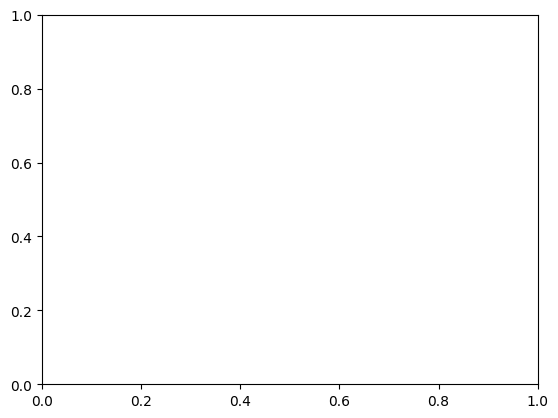

In [70]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

y_lower = 10
fig, ax = plt.subplots()
colors = cm.nipy_spectral(labels.astype(float) / VALOR_K)
for i in range(VALOR_K):
    # Agregando as silhuetas para clusters individuais
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
    y_upper = y_lower + len(cluster_silhouette_vals)

    color = cm.nipy_spectral(float(i) / VALOR_K)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Rótulos etc.
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
    y_lower = y_upper + 10  # Espaçamento para os próximos plots

ax.set_xlabel("Valores de Silhueta")
ax.set_ylabel("Clusters")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # Adiciona uma linha para o valor médio de silhueta
ax.set_yticks([])  # Limpa os rótulos de y-axis
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [62]:
from sklearn.metrics import davies_bouldin_score

VALOR_K = 5

# Construindo o melhor agrupador de clusteres
agrupador = KMeans(n_clusters=VALOR_K, random_state=1337)
agrupador.fit(df_pipe_cluster)

# Obtendo os rótulos dos clusters
labels = agrupador.labels_
davies_bouldin = davies_bouldin_score(df_pipe_cluster, labels)
print(f"Índice Davies-Bouldin: {davies_bouldin}")

Índice Davies-Bouldin: 0.7685315483071788


In [58]:
from sklearn.metrics import silhouette_score

VALOR_K = 6

# Construindo o melhor agrupador de clusteres
agrupador = KMeans(n_clusters=VALOR_K, random_state=1337)
agrupador.fit_transform(df_pipe_cluster)

# Calculando o Silhouete (qualidade dos clusters, separação intra cluster e inter cluster)
labels = agrupador.labels_
silhouette_avg = silhouette_score(df_pipe_cluster, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4990510586148022


In [63]:
from sklearn.metrics import davies_bouldin_score

VALOR_K = 6

# Construindo o melhor agrupador de clusteres
agrupador = KMeans(n_clusters=VALOR_K, random_state=1337)
agrupador.fit(df_pipe_cluster)

# Obtendo os rótulos dos clusters
labels = agrupador.labels_
davies_bouldin = davies_bouldin_score(df_pipe_cluster, labels)
print(f"Índice Davies-Bouldin: {davies_bouldin}")

Índice Davies-Bouldin: 0.7611430806908994


In [59]:
from sklearn.metrics import silhouette_score

VALOR_K = 7

# Construindo o melhor agrupador de clusteres
agrupador = KMeans(n_clusters=VALOR_K, random_state=1337)
agrupador.fit_transform(df_pipe_cluster)

# Calculando o Silhouete (qualidade dos clusters, separação intra cluster e inter cluster)
labels = agrupador.labels_
silhouette_avg = silhouette_score(df_pipe_cluster, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4521407318798386


In [64]:
from sklearn.metrics import davies_bouldin_score

VALOR_K = 7

# Construindo o melhor agrupador de clusteres
agrupador = KMeans(n_clusters=VALOR_K, random_state=1337)
agrupador.fit(df_pipe_cluster)

# Obtendo os rótulos dos clusters
labels = agrupador.labels_
davies_bouldin = davies_bouldin_score(df_pipe_cluster, labels)
print(f"Índice Davies-Bouldin: {davies_bouldin}")

Índice Davies-Bouldin: 0.7643401662696123


In [65]:
from sklearn.metrics import silhouette_score

VALOR_K = 4

# Construindo o melhor agrupador de clusteres
agrupador = KMeans(n_clusters=VALOR_K, random_state=1337)
agrupador.fit_transform(df_pipe_cluster)

# Calculando o Silhouete (qualidade dos clusters, separação intra cluster e inter cluster)
labels = agrupador.labels_
silhouette_avg = silhouette_score(df_pipe_cluster, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.43959266565322824


In [56]:
# df_pipe_cluster = df_pipe_cluster.drop(columns='label_cluster')
df_pipe_cluster

,,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,label_cluster
id_pessoa,tipo_divida,,,,,
a9380528004fde0c,imovel,4.0,2,0,1.0,0
3fe61940123c745e,imovel,4.0,2,2,1.0,0
bbdeb115fc331481,imovel,4.0,4,0,1.0,0
3fe4eef9f75aa82f,imovel,4.0,3,0,1.0,0
df73581ac769e6ed,imovel,4.0,6,5,1.0,4
...,...,...,...,...,...,...
70e6ea339a1ad658,mercantil,0.0,3,0,0.0,2
70e6cdc99b4ca03f,mercantil,0.0,4,0,0.0,2
70e63d8d49f8381d,imovel,1.0,3,0,0.0,2


In [57]:
pipe_cl_status_sit = df_pipe_cluster.groupby('situacao_cobranca')['label_cluster'].count().reset_index()
total = pipe_cl_status_sit['label_cluster'].sum()
pipe_cl_status_sit['total'] = total
pipe_cl_status_sit['perc'] = np.round(pipe_cl_status_sit['label_cluster']/total, 5)
pipe_cl_status_sit

,situacao_cobranca,label_cluster,total,perc
0,0.0,155504,337355,0.46095
1,1.0,21915,337355,0.06496
2,2.0,16930,337355,0.05018
3,3.0,15140,337355,0.04488
4,4.0,127866,337355,0.37903


In [58]:
df_pipe_cluster.groupby('label_cluster').count()

,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor
label_cluster,,,,
0,92116,92116,92116,92116
1,3809,3809,3809,3809
2,159377,159377,159377,159377
3,51705,51705,51705,51705
4,30348,30348,30348,30348


# Centroide

In [60]:
df_centroide # k = 5

# k = 5
# situacao_cobranca	num_dist_cda	quantidade_reparcelamento	historico_pagamento_em_valor	cluster
# 0.089	            3.662	        0.331	                    0.083	                        0       # Não paga e não é acessível --- 'DEVEDOR PESSIMO'
# 2.895	            6.357	        8.355	                    0.377	                        1       # Paga reparcelando e é acessível --- 'DEVEDOR BOM'
# 3.907	            3.027	        1.340	                    0.423	                        2       # Paga mais em cota única e é muito acessível -- 'DEVEDOR EXCEL'
# 2.827	            10.182	        25.449	                    0.255	                        3       # Reparcela muito com muitas dívidas e paga parte além de ser acessível --- 'DEVEDOR CONTUMAZ'
# 2.506             7.684           0.813                       0.124                           4       # Tem um número considerável de dívidas paga bem pouco e é pouco acessível --- 'DEVEDOR RUIM'

# situacao_cobranca	num_dist_cda	quantidade_reparcelamento	historico_pagamento_em_valor	cluster
# 3.734	            2.976	        1.368	                    0.426	                        0       # Paga mais em cota única e é muito acessível -- 'DEVEDOR EXCEL' 
# 3.259	            10.182	        25.449	                    0.255	                        1       # Reparcela muito com muitas dívidas e paga parte além de ser acessível --- 'DEVEDOR CONTUMAZ'
# 0.174	            3.708	        0.246	                    0.058	                        2       # Não paga e não é acessível --- 'DEVEDOR PESSIMO'
# 2.556	            7.621	        0.790	                    0.122	                        3       # Tem um número considerável de dívidas paga bem pouco e é pouco acessível --- 'DEVEDOR RUIM'
# 3.177             6.384           8.338                       0.377                           4       # Paga reparcelando e é acessível --- 'DEVEDOR BOM'

,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,cluster
0,3.734,2.976,1.368,0.426,0
1,3.259,10.182,25.449,0.255,1
2,0.174,3.708,0.246,0.058,2
3,2.556,7.621,0.790,0.122,3
4,3.177,6.384,8.338,0.377,4


In [232]:
df_centroide # k = 6

# k = 5
# situacao_cobranca	num_dist_cda	quantidade_reparcelamento	historico_pagamento_em_valor	cluster
# 0.173	            3.704	        0.215	                    0.055	                        0       # Não  paga, poucas dívidas, inacessível - DEVEDOR PESSIMO
# 3.225	            8.224	        14.149	                    0.315	                        1       # Paga bem reparcelando, bastante dívidas, bem acessível - DEVEDOR REPARCELADOR
# 3.255	            5.257	        5.785	                    0.415	                        2       # Paga negociando, dívidas razoáveis, bem acessível - DEVEDOR NEGOCIADOR
# 3.270	            11.427	        34.419	                    0.221	                        3       # Paga medio reparcelando muito, muitas dívidas , bem acessível - DEVEDOR CONTUMAZ
# 3.733	            2.878	        0.997	                    0.421	                        4       # Paga sem reparcelar, pouquíssimas dívidas, muito acessível - DEVEDOR EXCELENTE
# 2.491	            7.692	        0.608	                    0.105	                        5       # Paga pouco, dividas médias, medio acessível - DEVEDOR RUIM 

,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,cluster
0,0.173,3.704,0.215,0.055,0
1,3.225,8.224,14.149,0.315,1
2,3.255,5.257,5.785,0.415,2
3,3.270,11.427,34.419,0.221,3
4,3.733,2.878,0.997,0.421,4
5,2.491,7.692,0.608,0.105,5


In [61]:
dicionario_clusteres = {
    'class_contribuinte': [0, 1, 2, 3, 4, 5],
    'class_contribuinte_nome': ['DEVEDOR EXCELENTE',
                                'DEVEDOR CONTUMAZ',
                                'DEVEDOR PESSIMO',                              
                                'DEVEDOR RUIM',
                                'DEVEDOR BOM',                                
                                'PRIMEIRA DIVIDA'],
 
    'class_contribuinte_perfil': ['PAGA MUITO BEM',
                                'FREQUENTE EM DÍVIDA',
                                'NÃO PAGA',
                                'PAGA POUCO',                                
                                'PAGA BEM',                                                               
                                'NOVO EM DIVIDA']
}
 
df_dicionario_clusteres = pd.DataFrame(dicionario_clusteres)
df_dicionario_clusteres

,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil
0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM
1,1,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA
2,2,DEVEDOR PESSIMO,NÃO PAGA
3,3,DEVEDOR RUIM,PAGA POUCO
4,4,DEVEDOR BOM,PAGA BEM
5,5,PRIMEIRA DIVIDA,NOVO EM DIVIDA


In [66]:
# pessoas_da_aberto_0 = pd.merge(pessoas_da_aberto_0,
#          df_dicionario_clusteres,
#          on = "class_contribuinte",
#          how = "left")
 
#pessoas_da_aberto_0.columns

In [ ]:
# pessoas_da_aberto_1 = pd.merge(pessoas_da_aberto_1,
#          df_dicionario_clusteres,
#          on = "situacao_cobranca",
#          how = "left")
 
# pessoas_da_aberto_1

------------------------

# Primeira Divida

In [62]:
# Para ter uma noção de quem seria o centroide
df_primeira_divida = pessoas_da_aberto_0.query("num_dist_cda == 1")

# Imputando historico_pagamento_em_valor = 1 nos casos que passa de 1
# ESCOLHA DA LARISSA
df_primeira_divida.loc[df_primeira_divida['historico_pagamento_em_valor'] > 1, 'historico_pagamento_em_valor'] = 1
df_primeira_divida

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
5,1a1b950095e3dcfb,mercantil,1,0,369.42,369.42,114.0,0.0,INAPTO,1,0,1.0,2.0,1.0,POUCO ACESSÍVEL
6,df73156f4fffa6cb,imovel,1,0,77.25,77.25,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455126,70dfa0dd50acdc81,imovel,1,0,2532.93,0.00,0.0,1.0,ATIVO,1,1,2.0,4.0,0.0,MUITO ACESSÍVEL
455134,70e836b105bf5957,mercantil,1,0,118.33,0.00,0.0,0.0,ATIVO,1,1,1.0,3.0,0.0,BEM ACESSÍVEL
455136,70e7b7e331f1a65f,mercantil,1,0,2598.68,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.0,INACESSÍVEL
455142,70e6b402b1909b3e,mercantil,1,0,1499.27,0.00,0.0,0.0,INAPTO,1,1,0.0,0.0,0.0,INACESSÍVEL


### Comentários 1ª Dívida

#### 55% inacessível

#### 38% completamente acessível

In [63]:
prim_div_status_sit = df_primeira_divida.groupby('situacao_cobranca')['id_pessoa'].nunique().to_frame().reset_index()
total = prim_div_status_sit['id_pessoa'].sum()
prim_div_status_sit['total'] = total
prim_div_status_sit['perc'] = np.round(prim_div_status_sit['id_pessoa']/total, 5)
prim_div_status_sit

,situacao_cobranca,id_pessoa,total,perc
0,0.0,54381,117580,0.46250
1,1.0,3701,117580,0.03148
2,2.0,6957,117580,0.05917
3,3.0,7172,117580,0.06100
4,4.0,45369,117580,0.38586


In [64]:
data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)
df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']


# df_primeira_divida['historico_pagamento_em_qtd_faixas'] = pd.cut(df_primeira_divida['historico_pagamento_em_qtd'],
#                                 bins = igr_bins,
#                                 labels = igr_labels,
#                                 right = False)


df_primeira_divida['historico_pagamento_em_valor_faixas'] = pd.cut(df_primeira_divida['historico_pagamento_em_valor'],
                                bins = igr_bins,
                                labels = igr_labels,
                                right = False)

df_hist_pg_vlr = df_primeira_divida.groupby('historico_pagamento_em_valor_faixas')['historico_pagamento_em_valor_faixas'].count().to_frame()
total = df_hist_pg_vlr['historico_pagamento_em_valor_faixas'].sum()  
df_hist_pg_vlr['total'] = total
df_hist_pg_vlr['perc'] = np.round(df_hist_pg_vlr['historico_pagamento_em_valor_faixas']/total, 4)
df_hist_pg_vlr

,historico_pagamento_em_valor_faixas,total,perc
historico_pagamento_em_valor_faixas,,,
"[0.0, 0.01)",57189,117792,0.4855
"[0.01, 0.25)",7794,117792,0.0662
"[0.25, 0.5)",9298,117792,0.0789
"[0.5, 0.75)",3676,117792,0.0312
"[0.75, 0.99)",78,117792,0.0007
"[0.99, 1.0)",0,117792,0.0000
"[1.0, 1.01)",39757,117792,0.3375


## 48% dos 1ª dívida pagaram NADA
## 33% dos 1ª dívida pagaram TUDO

In [65]:
prim_div_sit = df_primeira_divida['situacao_cobranca'].mean()
prim_div_sit

1.872852146155936

In [66]:
prim_div_num_cda = df_primeira_divida['num_dist_cda'].mean()
prim_div_num_cda

1.0

In [67]:
prim_div_reparc = df_primeira_divida['quantidade_reparcelamento'].mean()
prim_div_reparc

0.3602281988590057

In [68]:
prim_div_hist_pg_vlr = df_primeira_divida['historico_pagamento_em_valor'].mean()
prim_div_hist_pg_vlr

0.3951767454462697

In [69]:
df_pipe_cluster.groupby('label_cluster').count()

,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor
label_cluster,,,,
0,92116,92116,92116,92116
1,3809,3809,3809,3809
2,159377,159377,159377,159377
3,51705,51705,51705,51705
4,30348,30348,30348,30348


In [70]:
df_centroide

,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,cluster
0,3.734,2.976,1.368,0.426,0
1,3.259,10.182,25.449,0.255,1
2,0.174,3.708,0.246,0.058,2
3,2.556,7.621,0.790,0.122,3
4,3.177,6.384,8.338,0.377,4


In [59]:
# # Salve o DataFrame em um arquivo CSV
# df_dicionario_clusteres.to_csv('data/df_dicionario_clusteres_AGRUP_COM_FREQ_PESSOAS_k4_maxpg.csv', index = False)  

Classificações dos contribuintes com base no melhor ao pior pagador, baseado no seu histórico e na sua situação atual.

# 04) Cria classificador de class do contribuinte

In [71]:
# Constroi o modelo que prevê qual o grupo do contribuinte

x_cluster = df_pipe_cluster.drop(columns=['label_cluster'])
y_cluster = df_pipe_cluster['label_cluster']

X_train, X_test, y_train, y_test = train_test_split(x_cluster, y_cluster, test_size=0.3, random_state=1337)

In [72]:
model_predict_contribuinte = RandomForestClassifier(random_state=1337)
model_predict_contribuinte.fit(X_train, y_train)

score_validacao = model_predict_contribuinte.score(X_test, y_test)
print("Score de validacao:", score_validacao)

Score de validacao: 0.9999604770421018


In [73]:
# Previsão da classificação para a base DA_ABERTO == 0 
matriz_previsao_class_da_aberto_0 = pessoas_da_aberto_0[['situacao_cobranca', 
                                 'num_dist_cda', 
                                 'quantidade_reparcelamento', 
                                 #'historico_pagamento_em_qtd', 
                                 'historico_pagamento_em_valor']]
pessoas_da_aberto_0['class_contribuinte'] = model_predict_contribuinte.predict(matriz_previsao_class_da_aberto_0)

pessoas_da_aberto_0.loc[pessoas_da_aberto_0['num_dist_cda'] == 1, 'class_contribuinte'] = VALOR_K

In [74]:
# Previsão da classificação para a base DA_ABERTO == 1
matriz_previsao_class_da_aberto_1 = pessoas_da_aberto_1[['situacao_cobranca', 
                                 'num_dist_cda', 
                                 'quantidade_reparcelamento', 
                                 #'historico_pagamento_em_qtd', 
                                 'historico_pagamento_em_valor']]
pessoas_da_aberto_1['class_contribuinte'] = model_predict_contribuinte.predict(matriz_previsao_class_da_aberto_1)

pessoas_da_aberto_1.loc[pessoas_da_aberto_1['num_dist_cda'] == 1, 'class_contribuinte'] = VALOR_K

In [75]:
#dados_pessoas = dados_pessoas.reset_index()
pessoas_da_aberto_0

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455142,70e6b402b1909b3e,mercantil,1,0,1499.27,0.00,0.0,0.0,INAPTO,1,1,0.0,0.0,0.0,INACESSÍVEL,5
455143,70e63d8d49f8381d,imovel,3,0,3207.50,0.00,0.0,0.0,EM PROCESSO DE BAIXA,1,1,0.0,1.0,0.0,POUQUISSIMO ACESSÍVEL,2
455144,70e5e39ede87cc82,mercantil,1,0,1833.70,0.00,0.0,0.0,INAPTO,0,1,0.0,0.0,0.0,INACESSÍVEL,5
455145,70e4ef8c182d3f70,mercantil,3,0,639.73,0.00,0.0,0.0,ATIVO,1,1,1.0,3.0,0.0,BEM ACESSÍVEL,0


In [76]:
pessoas_da_aberto_1

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte
0,6cb552c03bf16cb2,imovel,1,1,4050.95,3970.15,0.0,1.0,ATIVO,1,1,2.0,4.0,0.980054,MUITO ACESSÍVEL,5
1,9be83db9e45b9e75,imovel,1,0,1295.42,1219.92,0.0,1.0,ATIVO,1,1,2.0,4.0,0.941718,MUITO ACESSÍVEL,5
2,a815998acb8c6215,imovel,1,0,7490.13,6685.65,126.0,1.0,ATIVO,1,1,2.0,4.0,0.892595,MUITO ACESSÍVEL,5
3,a05b8e5ab1487772,imovel,2,0,3926.35,3471.16,0.0,1.0,ATIVO,1,1,2.0,4.0,0.884068,MUITO ACESSÍVEL,0
4,56eff1105d8f966e,imovel,1,0,149.18,118.74,0.0,1.0,ATIVO,1,1,2.0,4.0,0.795951,MUITO ACESSÍVEL,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279207,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,1,2.0,4.0,0.000000,MUITO ACESSÍVEL,0
279208,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,0,1.0,2.0,0.000000,POUCO ACESSÍVEL,5
279209,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.000000,INACESSÍVEL,2
279210,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,1,0.0,0.0,0.000000,INACESSÍVEL,5


# Exemplo mesmo id_pessoa em clusters diferentes por tipo_divida

In [77]:
pessoas_da_aberto_0[pessoas_da_aberto_0['id_pessoa'] == '000032f6d93a0abd'] 

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte
144972,000032f6d93a0abd,imovel,2,2,12715.63,3339.31,0.0,1.0,ATIVO,1,1,2.0,4.0,0.262615,MUITO ACESSÍVEL,0
352227,000032f6d93a0abd,mercantil,4,0,14553.60,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.000000,INACESSÍVEL,2


In [78]:
pessoas_da_aberto_0[pessoas_da_aberto_0['id_pessoa'] == '0000e13a7d8d7537'] 

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte
126337,0000e13a7d8d7537,mercantil,3,6,5874.45,1980.75,78.0,0.0,ATIVO,1,0,2.0,3.0,0.337181,BEM ACESSÍVEL,4
352225,0000e13a7d8d7537,imovel,6,0,5473.53,0.00,78.0,1.0,ATIVO,0,1,2.0,0.0,0.000000,INACESSÍVEL,2


# Quantos contribuintes tem CDA em imóvel e mercantil?

### 53.262

In [79]:
contrib_num_tipo_divida = da_aberto_0.groupby('id_pessoa')['tipo_divida'].nunique().to_frame().reset_index()
contrib_num_tipo_divida = contrib_num_tipo_divida.sort_values(by = 'tipo_divida', ascending = False)
contrib_02_tipo_divida = contrib_num_tipo_divida[contrib_num_tipo_divida['tipo_divida'] > 1]
contrib_02_tipo_divida = contrib_02_tipo_divida.drop(columns = 'tipo_divida')

contrib_num_dist_cda = da_aberto_0.groupby('id_pessoa')['cda'].nunique().to_frame().reset_index()
contrib_num_dist_cda = contrib_num_dist_cda.rename(columns = {'cda':'num_dist_cda'})
contrib_02_tipo_divida

,id_pessoa
198396,7fed88c8377ce689
68012,2bf9c7186cacea0a
68031,2bfbce39144ec095
338778,dad7efad32e192d3
338779,dad814f413233858
...,...
367787,ed618e1fe24b078f
237058,98f5ce6643b7ddb9
392677,fd541280f849f453
2196,015ddb2b3865386b


In [80]:
da_aberto_0_aux = da_aberto_0[["tipo_divida", "cda", "id_pessoa", "valor_tot"]]
contrib_02_tipo_divida = pd.merge(da_aberto_0_aux, contrib_02_tipo_divida, how = "right", on = "id_pessoa")

#contrib_02_tipo_divida = pd.merge(contrib_02_tipo_divida, contrib_num_dist_cda, how = "left", on = "id_pessoa")

contrib_02_tipo_divida = contrib_02_tipo_divida.sort_values(by = "id_pessoa")
contrib_02_tipo_divida

,tipo_divida,cda,id_pessoa,valor_tot
370650,mercantil,b269b3c8a08334b29fcacff532cf50c42,000032f6d93a0abd,1897.32
370646,imovel,5798154ce40edf871,000032f6d93a0abd,5404.26
370647,mercantil,83e8a51f206397736b3a8e268c80aedf2,000032f6d93a0abd,1096.59
370648,imovel,8ed62cf12b867b229ceed47545e621dd1,000032f6d93a0abd,7311.37
370649,mercantil,b208dd365dbb6b4c6b3a8e268c80aedf2,000032f6d93a0abd,9769.89
...,...,...,...,...
411941,imovel,18d555f0e536de151,fffeb78fd42d2624,7876.41
411940,imovel,13cba4131742a5604bd01ecb8277da0b1,fffeb78fd42d2624,12791.06
411939,imovel,0d0fb876260959bd9ceed47545e621dd1,fffeb78fd42d2624,9288.80
411946,imovel,fc3f9d49392410942b46f673bf0c61251,fffeb78fd42d2624,11072.39


In [81]:
contrib_02_tipo_divida_metrics = contrib_02_tipo_divida.groupby(['id_pessoa', 'tipo_divida']).agg({
    'cda': ['nunique'], 
    'valor_tot': ['sum']    
})

contrib_02_tipo_divida_metrics = contrib_02_tipo_divida_metrics.reset_index()

contrib_02_tipo_divida_metrics = pd.merge(contrib_02_tipo_divida_metrics, contrib_num_dist_cda, how = "left", on = "id_pessoa")

contrib_02_tipo_divida_metrics.sort_values(by = "id_pessoa")

,id_pessoa,"(id_pessoa, )","(tipo_divida, )","(cda, nunique)","(valor_tot, sum)",num_dist_cda
0,000032f6d93a0abd,000032f6d93a0abd,imovel,2,12715.63,6
1,000032f6d93a0abd,000032f6d93a0abd,mercantil,4,14553.60,6
2,0000e13a7d8d7537,0000e13a7d8d7537,imovel,6,5473.53,9
3,0000e13a7d8d7537,0000e13a7d8d7537,mercantil,3,5874.45,9
4,0001cc5c538504ce,0001cc5c538504ce,imovel,3,5035.34,4
...,...,...,...,...,...,...
116705,fffc4c97f1f6c954,fffc4c97f1f6c954,mercantil,2,1651.71,11
116706,fffe4c8195b51bd9,fffe4c8195b51bd9,imovel,2,1060.03,3
116707,fffe4c8195b51bd9,fffe4c8195b51bd9,mercantil,1,1833.70,3
116708,fffeb78fd42d2624,fffeb78fd42d2624,imovel,7,48399.00,8


In [82]:
# Salve o DataFrame em um arquivo CSV
contrib_02_tipo_divida_metrics.to_csv('data/contrib_02_tipo_divida_metrics_AGRUP_COM_FREQ_PESSOAS.csv', index = False)  

In [83]:
# Vendo as dívidas desses pessoas
contrib_02_tipo_divida_aux = contrib_02_tipo_divida[['tipo_divida',	'id_pessoa']]
contrib_02_tipo_divida_pessoas = pd.merge(contrib_02_tipo_divida_aux, pessoas_da_aberto_0, on = ['tipo_divida', 'id_pessoa'], how = 'left')
contrib_02_tipo_divida_pessoas = contrib_02_tipo_divida_pessoas.drop_duplicates()
contrib_02_tipo_divida_pessoas

,tipo_divida,id_pessoa,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte
0,mercantil,000032f6d93a0abd,4,0,14553.60,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.000000,INACESSÍVEL,2
1,imovel,000032f6d93a0abd,2,2,12715.63,3339.31,0.0,1.0,ATIVO,1,1,2.0,4.0,0.262615,MUITO ACESSÍVEL,0
6,mercantil,0000e13a7d8d7537,3,6,5874.45,1980.75,78.0,0.0,ATIVO,1,0,2.0,3.0,0.337181,BEM ACESSÍVEL,4
7,imovel,0000e13a7d8d7537,6,0,5473.53,0.00,78.0,1.0,ATIVO,0,1,2.0,0.0,0.000000,INACESSÍVEL,2
15,mercantil,0001cc5c538504ce,1,0,1390.90,0.00,0.0,0.0,SUSPENSO,1,0,0.0,0.0,0.000000,INACESSÍVEL,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414746,mercantil,fffc4c97f1f6c954,2,1,1651.71,46.47,0.0,0.0,BAIXADO,1,1,0.0,0.0,0.028134,INACESSÍVEL,2
414755,imovel,fffe4c8195b51bd9,2,0,1060.03,1060.03,0.0,1.0,ATIVO,1,1,2.0,4.0,1.000000,MUITO ACESSÍVEL,0
414757,mercantil,fffe4c8195b51bd9,1,0,1833.70,0.00,0.0,0.0,INAPTO,1,1,0.0,0.0,0.000000,INACESSÍVEL,5
414758,imovel,fffeb78fd42d2624,7,16,48399.00,8721.22,0.0,1.0,ATIVO,1,1,2.0,4.0,0.180194,MUITO ACESSÍVEL,4


# Como se distribuem os contribuintes com 2 tipos de divida

In [84]:
pessoas_da_aberto_0_aux = pessoas_da_aberto_0[["tipo_divida", "id_pessoa", "class_contribuinte"]]
contrib_02_tipo_divida_aux = contrib_02_tipo_divida[["tipo_divida", "id_pessoa"]].drop_duplicates()

In [85]:
contrib_02_tipo_divida_aux['id_pessoa'].nunique()

58355

In [86]:
aux = pd.merge(pessoas_da_aberto_0_aux, contrib_02_tipo_divida_aux, on = ["tipo_divida", "id_pessoa"], how = "left")
aux = aux.sort_values(by = 'id_pessoa')
aux_merc = aux[aux['tipo_divida'] == "mercantil"]
aux_imovel = aux[aux['tipo_divida'] == "imovel"]

aux_merc = aux_merc.drop(columns = 'tipo_divida')
aux_merc = pd.merge(aux_merc, df_dicionario_clusteres, on = 'class_contribuinte')
aux_merc = aux_merc.rename(columns = {'class_contribuinte':'class_contrib_mercantil',
                                      'class_contribuinte_nome':'class_contrib_nome_mercantil'})

aux_imovel = aux_imovel.drop(columns = 'tipo_divida')
aux_imovel = pd.merge(aux_imovel, df_dicionario_clusteres, on = 'class_contribuinte')
aux_imovel = aux_imovel.rename(columns = {'class_contribuinte':'class_contrib_imovel',
                                          'class_contribuinte_nome':'class_contrib_nome_imovel'})
#df_dicionario_clusteres
aux2 = pd.merge(aux_merc, aux_imovel, on = "id_pessoa", how = 'outer')


contingency_table = pd.crosstab(aux2[ 'class_contrib_nome_imovel'], aux2[ 'class_contrib_nome_mercantil'])
contingency_table

class_contrib_nome_mercantil,DEVEDOR BOM,DEVEDOR CONTUMAZ,DEVEDOR EXCELENTE,DEVEDOR PESSIMO,DEVEDOR RUIM,PRIMEIRA DIVIDA
class_contrib_nome_imovel,,,,,,
DEVEDOR BOM,192,25,508,3494,193,1945
DEVEDOR CONTUMAZ,27,3,72,439,30,243
DEVEDOR EXCELENTE,573,77,1710,10088,686,5965
DEVEDOR PESSIMO,226,28,606,4015,302,1845
DEVEDOR RUIM,416,51,1088,6678,431,3505
PRIMEIRA DIVIDA,387,51,1137,6840,489,3990


In [146]:
# dict = {"class_contribuinte_nome": ['PRIMEIRA DIVIDA', 
#                                     'RUIM INACESSIVEL', 
#                                     'NEGOC PAGA MÉDIO', #'CONTRIB NEGOCIADOR', 
#                                     'NEGOC PAGA BEM', #'CONTRIB NEGOCIADOR',
#                                     'PAGADOR ORGANICO'],
#          "ordem_contrib": [0, 1, 2 ,3, 4]}

# df_ordenar_class_contrib = pd.DataFrame(dict)
# df_ordenar_class_contrib

# Voltando para os agrupamentos

In [87]:
pessoas_da_aberto_0['da_aberto'] = 0
pessoas_da_aberto_1['da_aberto'] = 1

pessoas_completo_com_previsao = pd.concat([pessoas_da_aberto_0, pessoas_da_aberto_1])
pessoas_completo_com_previsao

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte,da_aberto
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279207,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,1,2.0,4.0,0.0,MUITO ACESSÍVEL,0,1
279208,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,0,1.0,2.0,0.0,POUCO ACESSÍVEL,5,1
279209,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.0,INACESSÍVEL,2,1
279210,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,1,0.0,0.0,0.0,INACESSÍVEL,5,1


In [88]:
df_dicionario_clusteres

,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil
0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM
1,1,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA
2,2,DEVEDOR PESSIMO,NÃO PAGA
3,3,DEVEDOR RUIM,PAGA POUCO
4,4,DEVEDOR BOM,PAGA BEM
5,5,PRIMEIRA DIVIDA,NOVO EM DIVIDA


In [89]:
# Nomeando a classificação com label de prioridade

pessoas_completo_com_previsao = pd.merge(pessoas_completo_com_previsao, 
         df_dicionario_clusteres, 
         on = "class_contribuinte",
         how = "left")

pessoas_completo_com_previsao

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte,da_aberto,class_contribuinte_nome,class_contribuinte_perfil
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734354,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,1,2.0,4.0,0.0,MUITO ACESSÍVEL,0,1,DEVEDOR EXCELENTE,PAGA MUITO BEM
734355,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,0,1.0,2.0,0.0,POUCO ACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA
734356,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.0,INACESSÍVEL,2,1,DEVEDOR PESSIMO,NÃO PAGA
734357,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,1,0.0,0.0,0.0,INACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA


In [90]:
# Incluindo variável 'tipo_divida'
df_classificao_contribuinte = pessoas_completo_com_previsao[['id_pessoa', 'tipo_divida', 'class_contribuinte_nome']]
df_classificao_contribuinte

,id_pessoa,tipo_divida,class_contribuinte_nome
0,a9380528004fde0c,imovel,DEVEDOR EXCELENTE
1,9a792def81ddfc26,imovel,PRIMEIRA DIVIDA
2,3fe61940123c745e,imovel,DEVEDOR EXCELENTE
3,1a1b1855bad67e4d,imovel,PRIMEIRA DIVIDA
4,df730d4bc706182c,imovel,PRIMEIRA DIVIDA
...,...,...,...
734354,553bc85dd5fcc0af,imovel,DEVEDOR EXCELENTE
734355,553c8e060b440331,mercantil,PRIMEIRA DIVIDA
734356,553d643170f814c8,mercantil,DEVEDOR PESSIMO
734357,553db2c93f67a5be,mercantil,PRIMEIRA DIVIDA


In [91]:
df_classificao_contribuinte.groupby('class_contribuinte_nome').count()

,id_pessoa,tipo_divida
class_contribuinte_nome,,
DEVEDOR BOM,34315,34315
DEVEDOR CONTUMAZ,4264,4264
DEVEDOR EXCELENTE,155352,155352
DEVEDOR PESSIMO,259121,259121
DEVEDOR RUIM,93701,93701
PRIMEIRA DIVIDA,187606,187606


# 05) Análise discriminante da classificação do contribuintes para o % Pago das dívidas de cada CDA

In [92]:
# Calcula variável target y
#pessoas_completo_com_previsao.loc[(pessoas_completo_com_previsao['valor_pago'].isna()) | (pessoas_completo_com_previsao['valor_pago'] == 0) , 'valor_pago'] = 1
pessoas_completo_com_previsao.loc[(pessoas_completo_com_previsao['valor_tot'].isna()) | (pessoas_completo_com_previsao['valor_tot'] == 0) , 'valor_tot'] = 1

pessoas_completo_com_previsao['percentual_pago_cda'] = pessoas_completo_com_previsao['valor_pago'] / pessoas_completo_com_previsao['valor_tot']

In [93]:
# Imputando historico_pagamento_em_valor = 1 nos casos que passa de 1
# ESCOLHA DA LARISSA
pessoas_completo_com_previsao.loc[pessoas_completo_com_previsao['percentual_pago_cda'] > 1, 'percentual_pago_cda'] = 1

In [94]:
pessoas_completo_com_previsao

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte,da_aberto,class_contribuinte_nome,class_contribuinte_perfil,percentual_pago_cda
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734354,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,1,2.0,4.0,0.0,MUITO ACESSÍVEL,0,1,DEVEDOR EXCELENTE,PAGA MUITO BEM,0.0
734355,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,0,1.0,2.0,0.0,POUCO ACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0
734356,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.0,INACESSÍVEL,2,1,DEVEDOR PESSIMO,NÃO PAGA,0.0
734357,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,1,0.0,0.0,0.0,INACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0


In [95]:
# Separação dos dados para a análise discriminante dos grupos de contribuintes
# df_analise_discriminante = pd.merge(
#     left = pessoas_completo_com_previsao, 
#     right = df_classificao_contribuinte, 
#     on = ['id_pessoa', 'tipo_divida'], 
#     how = 'left'
# )

df_analise_discriminante = pessoas_completo_com_previsao[['id_pessoa', 'tipo_divida', 'percentual_pago_cda', 'class_contribuinte_nome']]

In [96]:
df_analise_discriminante = df_analise_discriminante.set_index(['id_pessoa', 'tipo_divida'])
df_analise_discriminante

,,percentual_pago_cda,class_contribuinte_nome
id_pessoa,tipo_divida,,
a9380528004fde0c,imovel,1.0,DEVEDOR EXCELENTE
9a792def81ddfc26,imovel,1.0,PRIMEIRA DIVIDA
3fe61940123c745e,imovel,1.0,DEVEDOR EXCELENTE
1a1b1855bad67e4d,imovel,1.0,PRIMEIRA DIVIDA
df730d4bc706182c,imovel,1.0,PRIMEIRA DIVIDA
...,...,...,...
553bc85dd5fcc0af,imovel,0.0,DEVEDOR EXCELENTE
553c8e060b440331,mercantil,0.0,PRIMEIRA DIVIDA
553d643170f814c8,mercantil,0.0,DEVEDOR PESSIMO


In [97]:
df_analise_discriminante = df_analise_discriminante.reset_index()#.groupby("class_contribuinte_nome").describe().T
df_analise_discriminante

,id_pessoa,tipo_divida,percentual_pago_cda,class_contribuinte_nome
0,a9380528004fde0c,imovel,1.0,DEVEDOR EXCELENTE
1,9a792def81ddfc26,imovel,1.0,PRIMEIRA DIVIDA
2,3fe61940123c745e,imovel,1.0,DEVEDOR EXCELENTE
3,1a1b1855bad67e4d,imovel,1.0,PRIMEIRA DIVIDA
4,df730d4bc706182c,imovel,1.0,PRIMEIRA DIVIDA
...,...,...,...,...
734354,553bc85dd5fcc0af,imovel,0.0,DEVEDOR EXCELENTE
734355,553c8e060b440331,mercantil,0.0,PRIMEIRA DIVIDA
734356,553d643170f814c8,mercantil,0.0,DEVEDOR PESSIMO
734357,553db2c93f67a5be,mercantil,0.0,PRIMEIRA DIVIDA


In [98]:
# Dummyzando a variável de classificação 

ohe = OneHotEncoder(dtype=int)

colunas_ohe = ohe.fit_transform(df_analise_discriminante[['class_contribuinte_nome']]).toarray()
df_2 = pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names_out(['class_contribuinte_nome']))
df_2 

,class_contribuinte_nome_DEVEDOR BOM,class_contribuinte_nome_DEVEDOR CONTUMAZ,class_contribuinte_nome_DEVEDOR EXCELENTE,class_contribuinte_nome_DEVEDOR PESSIMO,class_contribuinte_nome_DEVEDOR RUIM,class_contribuinte_nome_PRIMEIRA DIVIDA
0,0,0,1,0,0,0
1,0,0,0,0,0,1
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,0,0,0,1
...,...,...,...,...,...,...
734354,0,0,1,0,0,0
734355,0,0,0,0,0,1
734356,0,0,0,1,0,0
734357,0,0,0,0,0,1


In [99]:
df_n_categorico = df_analise_discriminante.drop(columns=['class_contribuinte_nome'], axis=1)
df_n_categorico

,id_pessoa,tipo_divida,percentual_pago_cda
0,a9380528004fde0c,imovel,1.0
1,9a792def81ddfc26,imovel,1.0
2,3fe61940123c745e,imovel,1.0
3,1a1b1855bad67e4d,imovel,1.0
4,df730d4bc706182c,imovel,1.0
...,...,...,...
734354,553bc85dd5fcc0af,imovel,0.0
734355,553c8e060b440331,mercantil,0.0
734356,553d643170f814c8,mercantil,0.0
734357,553db2c93f67a5be,mercantil,0.0


In [100]:
df_pipe_discriminante = pd.concat([df_n_categorico, df_2], axis=1)

In [101]:
df_pipe_discriminante = df_pipe_discriminante.set_index(['id_pessoa', 'tipo_divida'])
df_pipe_discriminante

,,percentual_pago_cda,class_contribuinte_nome_DEVEDOR BOM,class_contribuinte_nome_DEVEDOR CONTUMAZ,class_contribuinte_nome_DEVEDOR EXCELENTE,class_contribuinte_nome_DEVEDOR PESSIMO,class_contribuinte_nome_DEVEDOR RUIM,class_contribuinte_nome_PRIMEIRA DIVIDA
id_pessoa,tipo_divida,,,,,,,
a9380528004fde0c,imovel,1.0,0,0,1,0,0,0
9a792def81ddfc26,imovel,1.0,0,0,0,0,0,1
3fe61940123c745e,imovel,1.0,0,0,1,0,0,0
1a1b1855bad67e4d,imovel,1.0,0,0,0,0,0,1
df730d4bc706182c,imovel,1.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
553bc85dd5fcc0af,imovel,0.0,0,0,1,0,0,0
553c8e060b440331,mercantil,0.0,0,0,0,0,0,1
553d643170f814c8,mercantil,0.0,0,0,0,1,0,0


In [102]:
x_analise_discriminante = df_pipe_discriminante.drop(columns=['percentual_pago_cda'])
y_analise_discriminante = df_pipe_discriminante['percentual_pago_cda'].astype('int')

In [103]:
analise_discriminante = LinearDiscriminantAnalysis()
analise_discriminante.fit(x_analise_discriminante, y_analise_discriminante)

LinearDiscriminantAnalysis()

In [104]:
dados_analise_disc = {'variavel': analise_discriminante.feature_names_in_, 'coeficiente' : analise_discriminante.coef_[0].round(5)}
pesos_analise_disc = pd.DataFrame(dados_analise_disc).sort_values('variavel').reset_index().drop(columns=['index'])

In [105]:
pesos_analise_disc

# 0	class_contribuinte_nome_DEVEDOR BOM	    -1.04310
# 1	class_contribuinte_nome_DEVEDOR EXCEL	 0.10483
# 2	class_contribuinte_nome_DEVEDOR PESSIMO	-1.01883
# 3	class_contribuinte_nome_DEVEDOR RUIM	-1.27335
# 4	class_contribuinte_nome_PRIMEIRA DIVIDA	 1.56033

,variavel,coeficiente
0,class_contribuinte_nome_DEVEDOR BOM,-0.96509
1,class_contribuinte_nome_DEVEDOR CONTUMAZ,-1.20205
2,class_contribuinte_nome_DEVEDOR EXCELENTE,0.53375
3,class_contribuinte_nome_DEVEDOR PESSIMO,-1.00789
4,class_contribuinte_nome_DEVEDOR RUIM,-1.02688
5,class_contribuinte_nome_PRIMEIRA DIVIDA,1.66216


In [106]:
pesos_ord = pesos_analise_disc.sort_values(by = 'coeficiente')['coeficiente'].reset_index().drop(columns = "index")
pesos_ord

,coeficiente
0,-1.20205
1,-1.02688
2,-1.00789
3,-0.96509
4,0.53375
5,1.66216


In [107]:
pesos_ord.sort_values(by = "coeficiente", inplace = True)

In [108]:
pesos_analise_disc2 = df_dicionario_clusteres
#pesos_analise_disc2['coeficiente'] = 
pesos_analise_disc2.loc[pesos_analise_disc2['class_contribuinte_nome'] == "DEVEDOR PESSIMO", 'coeficiente'] = pesos_ord.loc[0, "coeficiente"]
pesos_analise_disc2.loc[pesos_analise_disc2['class_contribuinte_nome'] == "DEVEDOR RUIM", 'coeficiente'] = pesos_ord.loc[1, "coeficiente"]
pesos_analise_disc2.loc[pesos_analise_disc2['class_contribuinte_nome'] == "DEVEDOR CONTUMAZ", 'coeficiente'] = pesos_ord.loc[2, "coeficiente"]
pesos_analise_disc2.loc[pesos_analise_disc2['class_contribuinte_nome'] == "DEVEDOR BOM", 'coeficiente'] = pesos_ord.loc[3, "coeficiente"]
pesos_analise_disc2.loc[pesos_analise_disc2['class_contribuinte_nome'] == "DEVEDOR EXCELENTE", 'coeficiente'] = pesos_ord.loc[5, "coeficiente"]
pesos_analise_disc2.loc[pesos_analise_disc2['class_contribuinte_nome'] == "PRIMEIRA DIVIDA", 'coeficiente'] = pesos_ord.loc[4, "coeficiente"]
pesos_analise_disc2

,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil,coeficiente
0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.66216
1,1,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,-1.00789
2,2,DEVEDOR PESSIMO,NÃO PAGA,-1.20205
3,3,DEVEDOR RUIM,PAGA POUCO,-1.02688
4,4,DEVEDOR BOM,PAGA BEM,-0.96509
5,5,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.53375


In [109]:
pesos_analise_disc2.sort_values(by = "coeficiente", inplace = True)
pesos_analise_disc2

,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil,coeficiente
2,2,DEVEDOR PESSIMO,NÃO PAGA,-1.20205
3,3,DEVEDOR RUIM,PAGA POUCO,-1.02688
1,1,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,-1.00789
4,4,DEVEDOR BOM,PAGA BEM,-0.96509
5,5,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.53375
0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.66216


In [130]:
# pesos_analise_disc2['class_contribuinte_nome'] = pesos_analise_disc2['variavel'].str.replace('class_contribuinte_nome_', '')
# pesos_analise_disc2

In [131]:
# Salve o DataFrame em um arquivo CSV
pesos_analise_disc2.to_csv('data/pesos_analise_disc_AGRUP_COM_FREQ_PESSOAS_maxpg.csv', index = False)  

# 06) Salva o modelo de classificação dos contribuintes

In [110]:
def salva_modelo_serializado(nome_modelo_serializado, modelo):
    sav_best_model = open(nome_modelo_serializado, 'wb')
    pickle.dump(modelo, sav_best_model)
    sav_best_model.close()

    pathModelo = modelsPath+"\\"+os.path.join(nome_modelo_serializado)
    shutil.move(os.path.abspath(nome_modelo_serializado), pathModelo)

In [111]:
salva_modelo_serializado("classificador-contribuinte_prime_k5_maxpg_luan.pkl", model_predict_contribuinte)

# SALVAR PESOS

In [ ]:
# # Use o método str.replace() para substituir o caractere '#' por uma string vazia na coluna 'texto'
# pesos_analise_disc['class_contribuinte_nome'] = pesos_analise_disc['variavel'].str.replace('class_contribuinte_nome_', '')
# pesos_analise_disc 

In [ ]:
# pesos_analise_disc = pd.merge(pesos_analise_disc, 
#          df_dicionario_clusteres, 
#          on = "class_contribuinte_nome",
#          how = "left")

# pesos_analise_disc  

In [ ]:
# # Salve o DataFrame em um arquivo CSV
# pesos_analise_disc.to_csv('data/pesos_analise_disc_AGRUP_COM_FREQ_PESSOAS_k4.csv', index = False)  

In [112]:
df_pipe_cluster

,,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,label_cluster
id_pessoa,tipo_divida,,,,,
a9380528004fde0c,imovel,4.0,2,0,1.0,0
3fe61940123c745e,imovel,4.0,2,2,1.0,0
bbdeb115fc331481,imovel,4.0,4,0,1.0,0
3fe4eef9f75aa82f,imovel,4.0,3,0,1.0,0
df73581ac769e6ed,imovel,4.0,6,5,1.0,4
...,...,...,...,...,...,...
70e6ea339a1ad658,mercantil,0.0,3,0,0.0,2
70e6cdc99b4ca03f,mercantil,0.0,4,0,0.0,2
70e63d8d49f8381d,imovel,1.0,3,0,0.0,2


# Distribuição dos Contribuintes

In [113]:
freq_classecontrib = pessoas_completo_com_previsao.groupby(['class_contribuinte_nome'])['id_pessoa'].nunique().to_frame().reset_index()
tot = freq_classecontrib['id_pessoa'].sum()
freq_classecontrib['perc'] = np.round(freq_classecontrib['id_pessoa']/tot, 4)
freq_classecontrib

,class_contribuinte_nome,id_pessoa,perc
0,DEVEDOR BOM,31082,0.0522
1,DEVEDOR CONTUMAZ,3808,0.0064
2,DEVEDOR EXCELENTE,127447,0.2140
3,DEVEDOR PESSIMO,188532,0.3165
4,DEVEDOR RUIM,83069,0.1395
5,PRIMEIRA DIVIDA,161663,0.2714


In [114]:
pessoas_completo_com_previsao.columns

Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca', 'class_contribuinte', 'da_aberto',
       'class_contribuinte_nome', 'class_contribuinte_perfil',
       'percentual_pago_cda'],
      dtype='object')

In [115]:
# da_aberto ==0
freq_classecontrib_da_aberto_0 = pessoas_completo_com_previsao[pessoas_completo_com_previsao['da_aberto'] == 0].groupby(['class_contribuinte_nome'])['id_pessoa'].nunique().to_frame().reset_index()
tot = freq_classecontrib_da_aberto_0['id_pessoa'].sum()
freq_classecontrib_da_aberto_0['perc'] = np.round(freq_classecontrib_da_aberto_0['id_pessoa']/tot, 4)
freq_classecontrib_da_aberto_0

,class_contribuinte_nome,id_pessoa,perc
0,DEVEDOR BOM,30158,0.0678
1,DEVEDOR CONTUMAZ,3806,0.0086
2,DEVEDOR EXCELENTE,90405,0.2032
3,DEVEDOR PESSIMO,155362,0.3493
4,DEVEDOR RUIM,51273,0.1153
5,PRIMEIRA DIVIDA,113802,0.2558


In [116]:
# da_aberto == 1
freq_classecontrib_da_aberto_1 = pessoas_completo_com_previsao[pessoas_completo_com_previsao['da_aberto'] == 1].groupby(['class_contribuinte_nome'])['id_pessoa'].nunique().to_frame().reset_index()
tot = freq_classecontrib_da_aberto_1['id_pessoa'].sum()
freq_classecontrib_da_aberto_1['perc'] = np.round(freq_classecontrib_da_aberto_1['id_pessoa']/tot, 4)
freq_classecontrib_da_aberto_1

,class_contribuinte_nome,id_pessoa,perc
0,DEVEDOR BOM,3958,0.0144
1,DEVEDOR CONTUMAZ,455,0.0017
2,DEVEDOR EXCELENTE,62430,0.2277
3,DEVEDOR PESSIMO,97557,0.3558
4,DEVEDOR RUIM,41542,0.1515
5,PRIMEIRA DIVIDA,68263,0.2489


In [ ]:
#df_ordenar_class_contrib

In [140]:
# freq_classecontrib = pd.merge(
#     left = freq_classecontrib, 
#     right = df_ordenar_class_contrib,
#     on = 'class_contribuinte_nome',
#     how = "left"
# )

# freq_classecontrib = freq_classecontrib.sort_values(by = ['ordem_contrib'])
# total = freq_classecontrib['id_pessoa'].sum()
# freq_classecontrib['total'] = total
# freq_classecontrib

,class_contribuinte_nome,id_pessoa,perc,ordem_contrib,coeficiente,total
3,PRIMEIRA DIVIDA,161637,0.2931,0,-0.04597,551430
4,RUIM INACESSIVEL,197550,0.3583,1,-1.21937,551430
1,NEGOC PAGA MÉDIO,3838,0.0070,2,-0.98984,551430
0,NEGOC PAGA BEM,33621,0.0610,3,-0.96854,551430
2,PAGADOR ORGANICO,154784,0.2807,4,1.60383,551430


In [141]:
# # Salve o DataFrame em um arquivo CSV
# freq_classecontrib.to_csv('data/distribuicao_contribuintes_AGRUP_COM_FREQ_PESSOAS_k4_maxpg.csv', index = False)  

# Previsão

In [ ]:
# matriz_previsao_class = pessoas[['situacao_cobranca', 'num_dist_cda', 'quantidade_reparcelamento', 'historico_pagamento_em_valor']]
# matriz_previsao_class

In [ ]:
# pessoas['class_contribuinte'] = model_predict_contribuinte.predict(matriz_previsao_class)
# pessoas

In [ ]:
# pessoas.loc[pessoas['num_dist_cda'] == 1, 'class_contribuinte'] = 0
# pessoas

# Pesos dos Contribuintes

In [117]:
#pesos_analise_disc_aux = pesos_analise_disc[["coeficiente",	"class_contribuinte_nome",	"class_contribuinte"]]
pesos_analise_disc2#_aux

,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil,coeficiente
2,2,DEVEDOR PESSIMO,NÃO PAGA,-1.20205
3,3,DEVEDOR RUIM,PAGA POUCO,-1.02688
1,1,DEVEDOR CONTUMAZ,FREQUENTE EM DÍVIDA,-1.00789
4,4,DEVEDOR BOM,PAGA BEM,-0.96509
5,5,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.53375
0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.66216


In [118]:
pessoas_completo_com_previsao

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,endereco_existe,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte,da_aberto,class_contribuinte_nome,class_contribuinte_perfil,percentual_pago_cda
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,1,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734354,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,1,2.0,4.0,0.0,MUITO ACESSÍVEL,0,1,DEVEDOR EXCELENTE,PAGA MUITO BEM,0.0
734355,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,0,1.0,2.0,0.0,POUCO ACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0
734356,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,0,0.0,0.0,0.0,INACESSÍVEL,2,1,DEVEDOR PESSIMO,NÃO PAGA,0.0
734357,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,1,0.0,0.0,0.0,INACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0


In [119]:
# Nomeando a classificação com label de prioridade
pessoas_completo_com_previsao = pd.merge(pessoas_completo_com_previsao, 
         pesos_analise_disc2, 
         on = ["class_contribuinte_nome"],
         how = "left")

pessoas_completo_com_previsao = pessoas_completo_com_previsao.rename(columns = {'coeficiente':'class_contribuinte_peso'})
pessoas_completo_com_previsao

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,...,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte_x,da_aberto,class_contribuinte_nome,class_contribuinte_perfil_x,percentual_pago_cda,class_contribuinte_y,class_contribuinte_perfil_y,class_contribuinte_peso
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,...,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0,0,PAGA MUITO BEM,1.66216
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,...,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0,5,NOVO EM DIVIDA,0.53375
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,...,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0,0,PAGA MUITO BEM,1.66216
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,...,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0,5,NOVO EM DIVIDA,0.53375
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,...,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0,5,NOVO EM DIVIDA,0.53375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734354,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,...,0.0,MUITO ACESSÍVEL,0,1,DEVEDOR EXCELENTE,PAGA MUITO BEM,0.0,0,PAGA MUITO BEM,1.66216
734355,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,...,0.0,POUCO ACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0,5,NOVO EM DIVIDA,0.53375
734356,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,...,0.0,INACESSÍVEL,2,1,DEVEDOR PESSIMO,NÃO PAGA,0.0,2,NÃO PAGA,-1.20205
734357,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,...,0.0,INACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0,5,NOVO EM DIVIDA,0.53375


In [120]:
pessoas_completo_com_previsao.columns

Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca', 'class_contribuinte_x', 'da_aberto',
       'class_contribuinte_nome', 'class_contribuinte_perfil_x',
       'percentual_pago_cda', 'class_contribuinte_y',
       'class_contribuinte_perfil_y', 'class_contribuinte_peso'],
      dtype='object')

In [122]:
pessoas_completo_com_previsao = pessoas_completo_com_previsao.drop(columns='class_contribuinte_perfil_y')
pessoas_completo_com_previsao.columns

Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca', 'class_contribuinte_x', 'da_aberto',
       'class_contribuinte_nome', 'class_contribuinte_perfil_x',
       'percentual_pago_cda', 'class_contribuinte_peso'],
      dtype='object')

In [124]:
pessoas_completo_com_previsao = pessoas_completo_com_previsao.rename(columns = {'class_contribuinte_x':'class_contribuinte'})
pessoas_completo_com_previsao.columns

Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca', 'class_contribuinte', 'da_aberto',
       'class_contribuinte_nome', 'class_contribuinte_perfil',
       'percentual_pago_cda', 'class_contribuinte_peso'],
      dtype='object')

# Feature store do Contribuinte

In [125]:
df_feature_store_contribuinte = pessoas_completo_com_previsao
df_feature_store_contribuinte
# df_feature_store_contribuinte = df_feature_store_contribuinte[['id_pessoa', 'situacao', 'cpf_existe', 'edificacao', 'qtd_notas_2anos', 
#                                                                'situacao_ativa', 'status_situacao', 
#                                                                'deb_totais','deb_pagos', 'valor_tot', 'valor_pago', 
#                                                                'frequencia_da_pessoa', 'total_debitos_pessoa', 'debitos_pagos_pessoa', 'valor_total_pessoa', 'valor_pago_pessoa', 
#                                                                'historico_pagamento_em_qtd', 'historico_pagamento_em_valor', 
#                                                                'class_contribuinte', 'class_contribuinte_nome', 'class_contribuinte_peso']]

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,...,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte,da_aberto,class_contribuinte_nome,class_contribuinte_perfil,percentual_pago_cda,class_contribuinte_peso
0,a9380528004fde0c,imovel,2,0,2413.14,2413.14,0.0,1.0,ATIVO,1,...,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0,1.66216
1,9a792def81ddfc26,imovel,1,1,383.69,383.69,0.0,1.0,ATIVO,1,...,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0,0.53375
2,3fe61940123c745e,imovel,2,2,641.73,641.73,0.0,1.0,ATIVO,1,...,2.0,4.0,1.0,MUITO ACESSÍVEL,0,0,DEVEDOR EXCELENTE,PAGA MUITO BEM,1.0,1.66216
3,1a1b1855bad67e4d,imovel,1,1,2361.16,2361.16,0.0,1.0,ATIVO,1,...,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0,0.53375
4,df730d4bc706182c,imovel,1,1,13412.65,13412.65,0.0,1.0,ATIVO,1,...,2.0,4.0,1.0,MUITO ACESSÍVEL,5,0,PRIMEIRA DIVIDA,NOVO EM DIVIDA,1.0,0.53375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734354,553bc85dd5fcc0af,imovel,2,0,1840.99,0.00,0.0,1.0,ATIVO,1,...,2.0,4.0,0.0,MUITO ACESSÍVEL,0,1,DEVEDOR EXCELENTE,PAGA MUITO BEM,0.0,1.66216
734355,553c8e060b440331,mercantil,1,0,1776.32,0.00,0.0,0.0,ATIVO,1,...,1.0,2.0,0.0,POUCO ACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0,0.53375
734356,553d643170f814c8,mercantil,2,0,7268.00,0.00,0.0,0.0,INAPTO,1,...,0.0,0.0,0.0,INACESSÍVEL,2,1,DEVEDOR PESSIMO,NÃO PAGA,0.0,-1.20205
734357,553db2c93f67a5be,mercantil,1,0,2648.20,0.00,0.0,0.0,SUSPENSO,1,...,0.0,0.0,0.0,INACESSÍVEL,5,1,PRIMEIRA DIVIDA,NOVO EM DIVIDA,0.0,0.53375


In [126]:
df_feature_store_contribuinte.groupby('class_contribuinte_nome')['id_pessoa'].nunique().to_frame().reset_index()

,class_contribuinte_nome,id_pessoa
0,DEVEDOR BOM,31082
1,DEVEDOR CONTUMAZ,3808
2,DEVEDOR EXCELENTE,127447
3,DEVEDOR PESSIMO,188532
4,DEVEDOR RUIM,83069
5,PRIMEIRA DIVIDA,161663


In [127]:
df_pipe_cluster

,,situacao_cobranca,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,label_cluster
id_pessoa,tipo_divida,,,,,
a9380528004fde0c,imovel,4.0,2,0,1.0,0
3fe61940123c745e,imovel,4.0,2,2,1.0,0
bbdeb115fc331481,imovel,4.0,4,0,1.0,0
3fe4eef9f75aa82f,imovel,4.0,3,0,1.0,0
df73581ac769e6ed,imovel,4.0,6,5,1.0,4
...,...,...,...,...,...,...
70e6ea339a1ad658,mercantil,0.0,3,0,0.0,2
70e6cdc99b4ca03f,mercantil,0.0,4,0,0.0,2
70e63d8d49f8381d,imovel,1.0,3,0,0.0,2


# Salvar no S3

In [128]:
print("Inicia a conexão com S3 para inscrição dos dados")
# Cria conexão ao s3 e preenche a tabela com os dados
s3_resource = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

NOME_ARQ_SALVAR_S3 = 'feature_store_contribuinte_prime_k5_maxpg_luan.csv'

up_s3_files(dataframe=df_feature_store_contribuinte, 
            bucket_name=os.getenv("S3_BUCKET_NAME"), 
            folder_name=os.getenv("S3_FOLDER_NAME"), 
            file_name= NOME_ARQ_SALVAR_S3)

print("Dados upados no s3")
print("Processo finalizado")

Inicia a conexão com S3 para inscrição dos dados
Dados upados no s3
Processo finalizado


In [ ]:
#"C:\Users\Consultor\Aquila\PM - Recife - 0599_21\_02_FASE 2\05. DÉBITO TRIBUTÁRIO\1. SEGMENTAÇÃO DO CONTRIBUINTE\Segmentação do Contribuinte_V2.pptx"